## Introduction

For this unsupervised learning project I knew I wanted to look into anomaly detection. When perusing datasets I found some very interesting ones in which I could detect anomalies. Among them were fault detection in power transmission grids, fault detection in rotational machinery, and anomaly detection in network data. I opted for the network data because the idea of having a ML solution to monitor network traffic and flag suspicious IP addresses was a cool idea. This type of problem is still an open question in research because it's difficult to pin down the reason behind anomaly activity. Is it just someone increasing their usage and downloading movies or is it a DoS attack. After researching about the topic I found that there are many different types of anomalies and they can be categorized in the figure below.  
![Types of Anomalies](types.png)

## Project Topic

In this final project, we will look at using different aggregations of network data to detect anomalous IP addresses. Detecting outliers in network data is crucial for computer security. Network anomalies can look like a variety of different indicators. They could range from spikes in packets, flows, bytes, or abnormal ratios of TCP/UDP traffic, or abnormal ratios of incoming/outgoing traffic. In this notebook, we aim to find any outliers of the features we are given. Instead of trying to label these IP addresses as attacks, my goal is to use an unsupervised approach to detect any type of anomaly in the data. We will explore how correlation patterns between features change across IPs, use boxplots to study distributions, and visualize feature distributions with histograms and kernel density estimates (KDEs).

#### Github
https://github.com/sam-ghala/fault_detection

In [6]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.stats import zscore
import matplotlib.dates as mdates

## Data Source
The datasets I gathered for this project are publicly aviable. The CESNET-Timeseries24 data can be downloaded from their website (found in the references). The data is organized into three entity groups—IP addresses, institutions, and institution subnets—and within each group it’s aggregated at three different time scales: 10-minute, 1-hour, and 1-day intervals.

| Aggregation | Number of Time Slots |
|:-----------:|---------------------:|
| 10 minutes  | 40,297                |
| 1 hour      | 6,717                 |
| 1 day       | 279                   |

#### Tree of datasets
ip_addresses_sample/  
├── agg_10_minutes/  
├── agg_1_hour/  
└── agg_1_day/  

institutions/  
├── agg_10_minutes/  
├── agg_1_hour/  
└── agg_1_day/  

institutions_subnets/  
├── agg_10_minutes/  
├── agg_1_hour/  
└── agg_1_day/  

#### Features
The features in this dataset focus on traffic volume and characteristics rather than packet contents. Below is a table of the available features.   
**id_time**: An integer to identify differnt times the data was taken in, so for each type of aggregation each id_time encapsulates 10 minutes, 1 hour, or 1 day of traffic.  
**n_flows**: An integer that indicates the number of different connecitons for the IP address.  
**n_packets**: An integer that indicaies the numver of packets sent over that time interval.  
**n_bytes**: An integer that indicates the number of bytes that was tramsitted during that time interaval.  
**sum_n_dest_asn**: Count of unique IP destinations.  
**average_n_dest_asn**: Average number of unique Autonomous System Numbers for destinations.  
**std_n_dest_asn**: Standard Deviation of unique ASN desinations.  
**sum_n_dest_ports**: Count of desintation IP ports.  
**average_n_dest_ports**: Average number of unique desintation ports.  
**std_n_dest_ports**: Standard deviation of desitnation ports.  
**sum_n_dest_ip**: Count of unique destination IP.  
**average_n_dest_ip**: Average number of destination IPs.  
**std_n_dest_ip**: Standard Deviation for number of unique destination IPs.  
**tcp_udp_ratio_packets** Ratio of TCP to UDP packet transmissoin, 1 means all packets were sent over TCP and 0 means all packets were sent over UDP.  
**tcp_udp_ratio_byte**: Ratio of TCP to UDP byte amount.   
**dir_ratio_packets**: Ratio of inbound to outbound packet flow, 1 is all packets sent to outgoing, 0 means all packets are incoming.  
**dir_ratio_bytes**: Ratio of inbound to outbound byte flow.  
**avg_duration**: Average Duration of packets for a session.  
**avg_ttl**: Average time to live for packets for a session.  
**timestamp**: Timestamp to actual time of each interval

## Data Description and Data Cleaning
Our data take different shapes depending on the branch you’re working with. The sample_IP_addresses directory was used in the beginning of this project to test performance metrics and visualizations. Once I got a model up and running I cleaned the institutions and institution_subnets data as well. For each CSV, I merged it with the master time index to ensure uniform timestamps. I also checked for inifite and missing values and dropped any other problematic values. And After looking at the KDE historgams we log-transformed the skew heavy counts such as n_flows_mean, n_packets_mean, n_bytes_mean. 

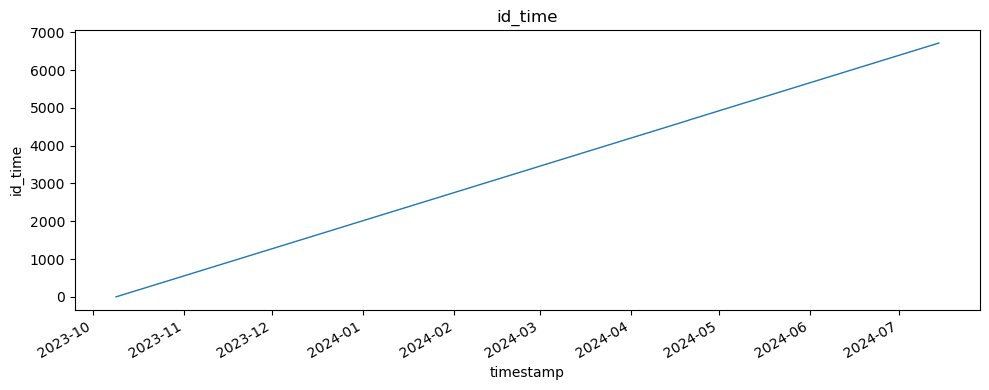

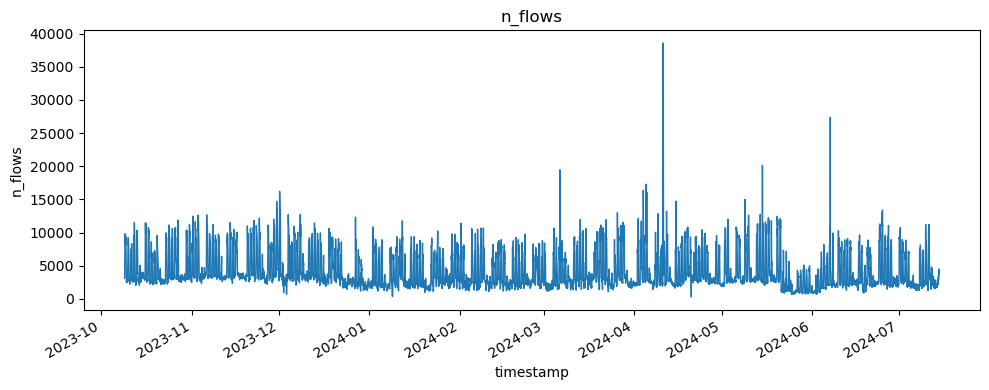

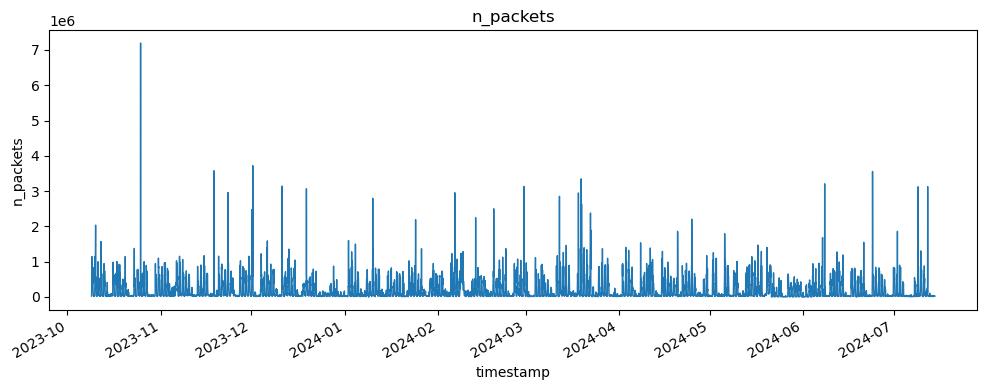

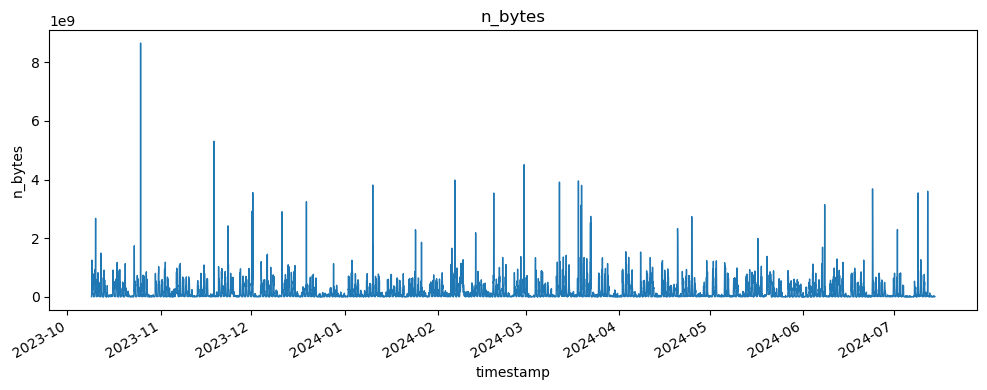

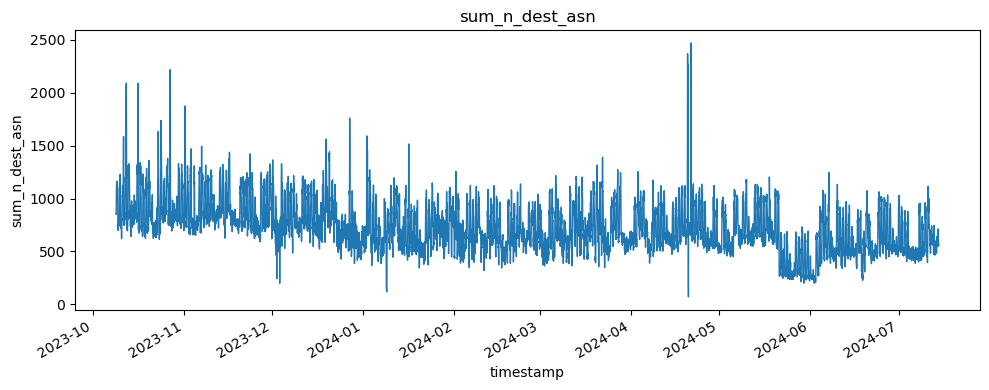

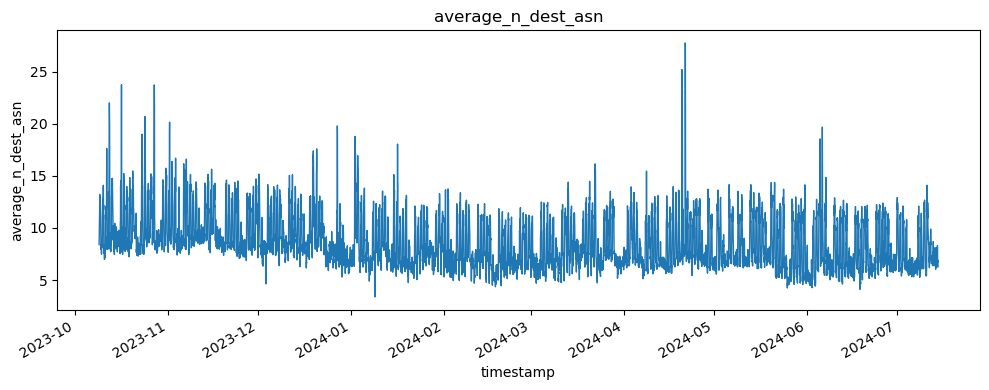

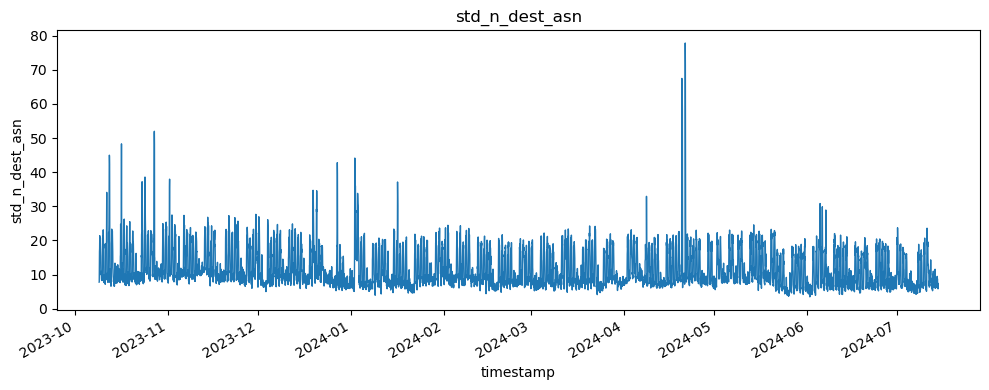

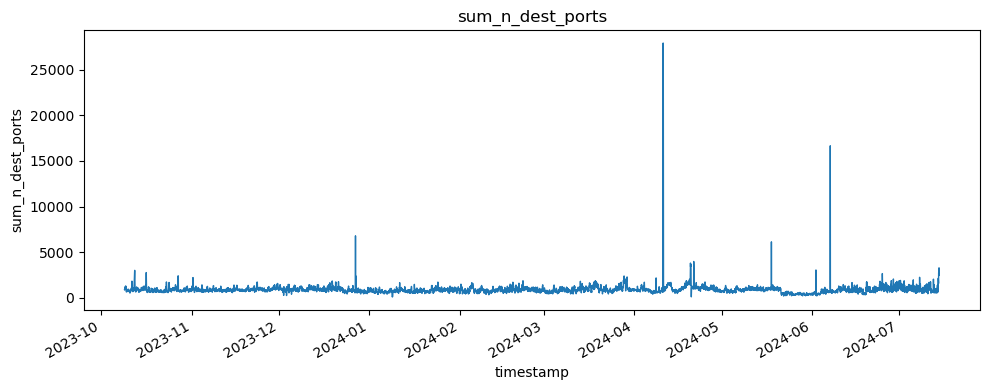

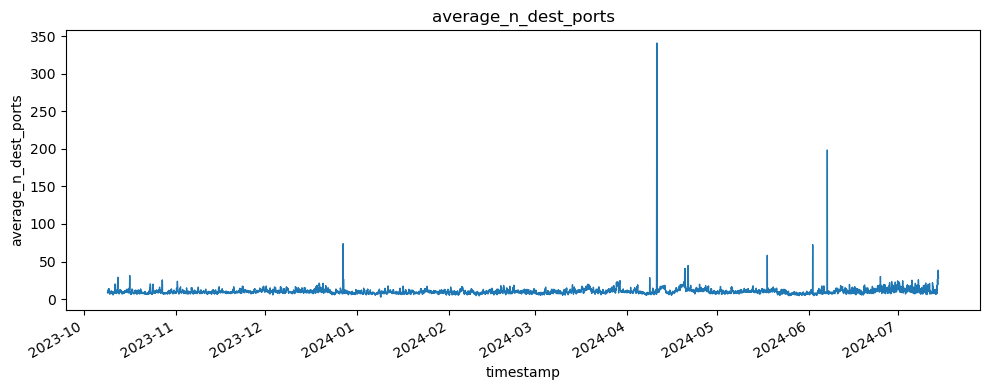

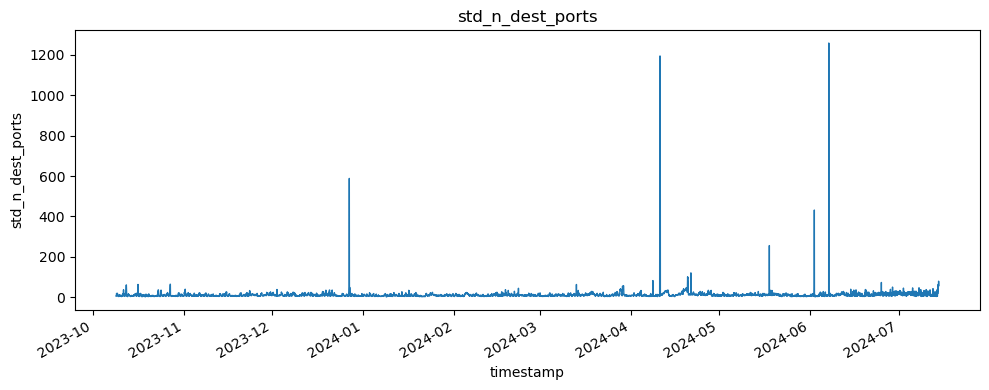

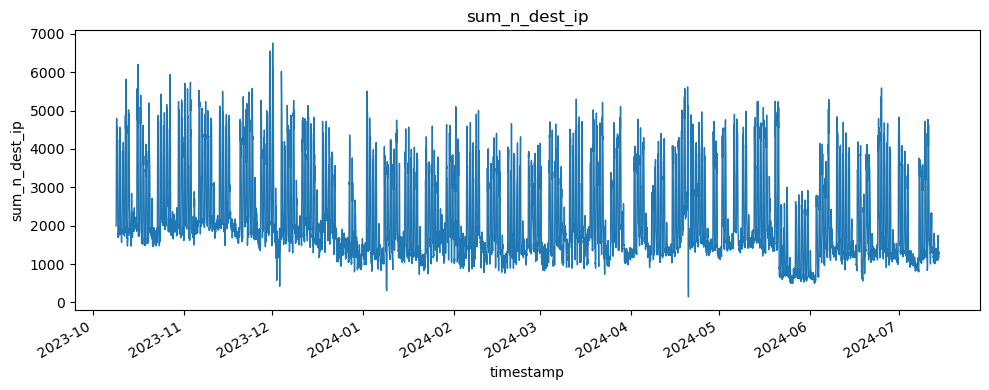

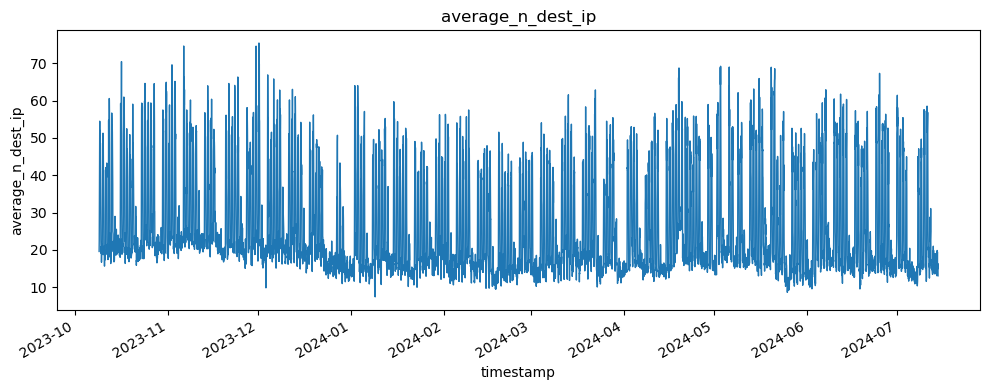

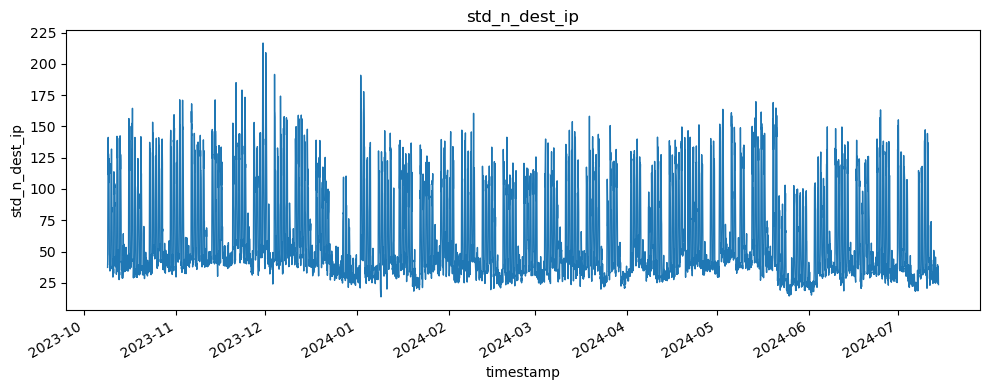

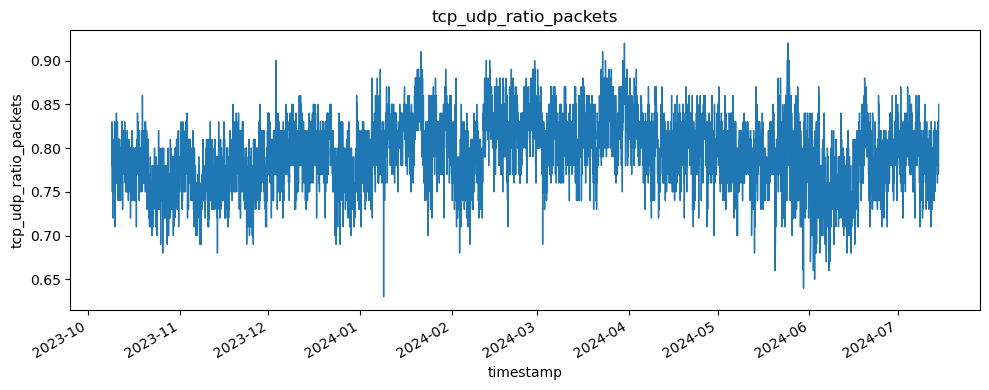

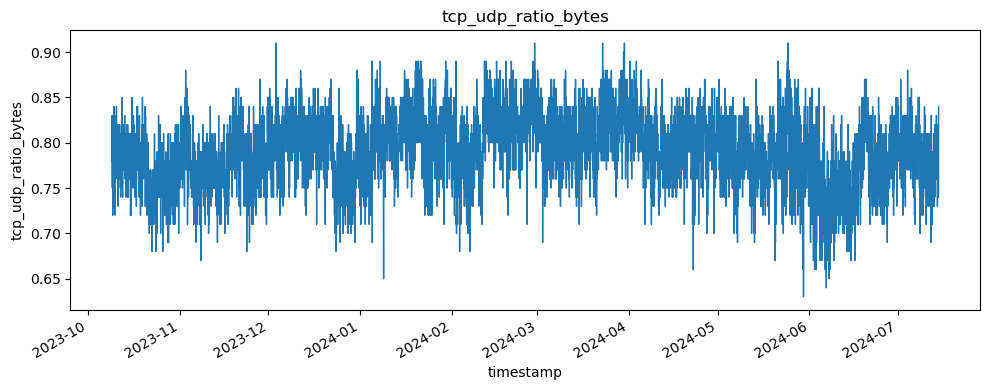

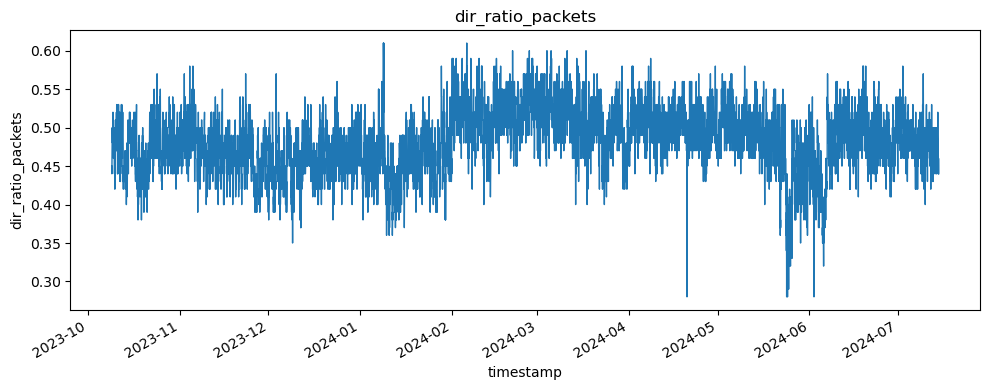

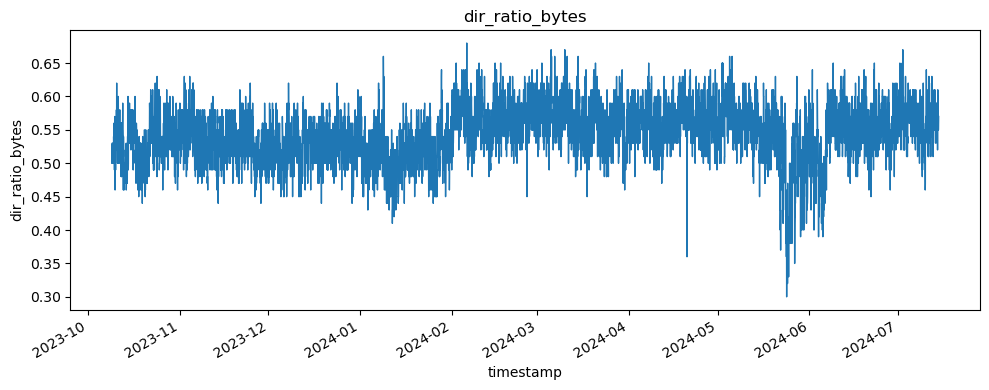

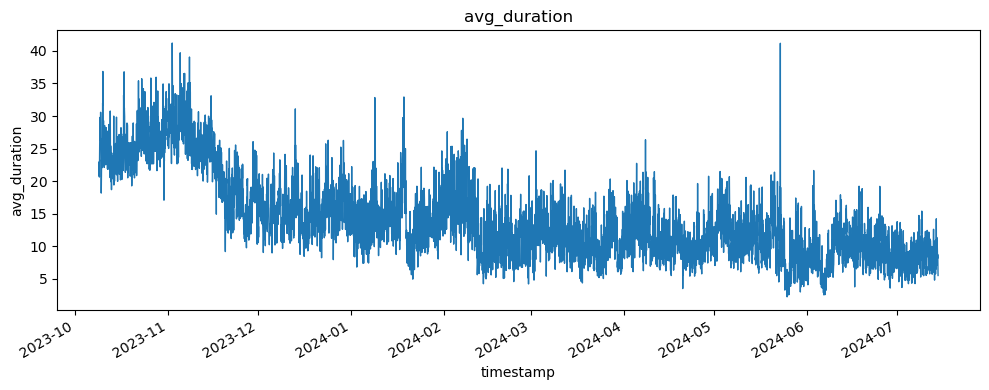

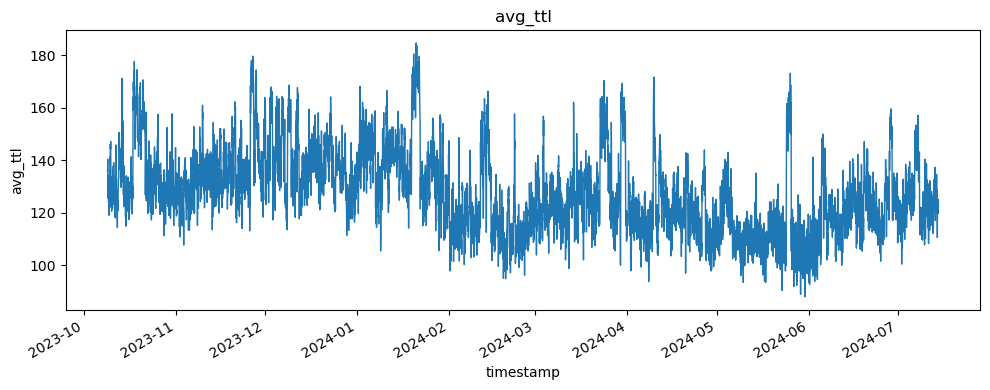

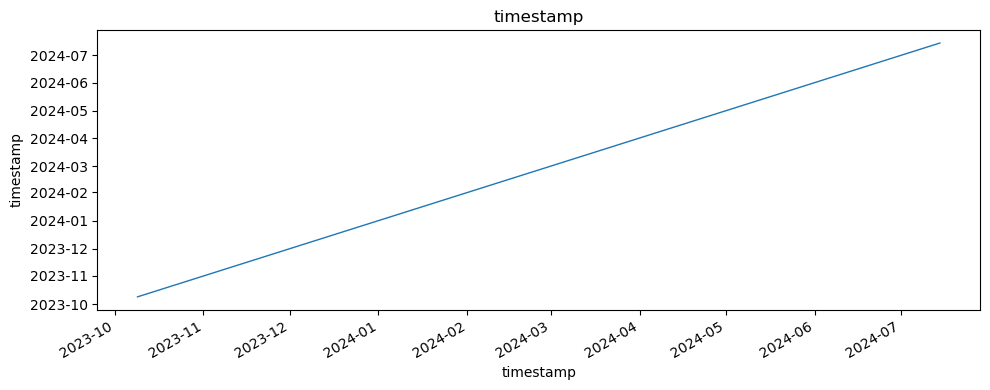

In [7]:
# Old inital way of loading data
data_paths = ['ip_addresses_sample/agg_10_minutes', # directories with CESNET-TimeSeries24 CSVs
         'ip_addresses_sample/agg_1_hour', 
         'ip_addresses_sample/agg_1_day',
         'institutions/agg_10_minutes',
         'institutions/agg_1_hour',
         'institutions/agg_1_day',
         'institution_subnets/agg_10_minutes',
         'institution_subnets/agg_1_hour',
         'institution_subnets/agg_1_day' ]
times = ['times/times_10_minutes.csv', 
         'times/times_1_hour.csv', 
         'times/times_1_day.csv']

data_group = 3 # 0 for ip_addresesses_sample, 3 for institutions, 6 for institutions_subnets
agg = 'hour' # main toggle to look at min,hour,or day aggegreation 

data_agg = {'min': (data_paths[data_group], times[0], 40297), 
            'hour':(data_paths[data_group + 1], times[1], 6717), 
            'day':(data_paths[data_group + 2], times[2], 279)}

df_time = pd.read_csv(data_agg[agg][1]) # 0 is minutes, 1 is hours, 2 is days

file_paths = glob.glob(os.path.join(data_agg[agg][0], '*.csv'))#[:num_ip]
ids = [os.path.splitext(os.path.basename(p))[0] for p in file_paths]
dfs = {ip_id : pd.read_csv(file_path) for ip_id, file_path in zip(ids,file_paths)}

del_ip = []
for ip, df in dfs.items():
    df['timestamp'] = df_time['time']
    if len(df) < data_agg[agg][2]:
        del_ip.append(ip)
for i in range(len(del_ip)):
    del dfs[del_ip[i]]

for feat in list(df.columns):
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(df['timestamp'], df[feat], lw=1)
    ax.set_title(feat)
    ax.set_ylabel(feat)
    ax.set_xlabel('timestamp')

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

## Exploratory Data Analysis
To begin our EDA, I first looked at the KDE histograms and found very skewed plots. As a result, I decided to log-transform n_flows, n_packets, and n_bytes. This nested for-loop gave me a much better sense of feature distribution and skew across each sub-dataset. I think this is important because on the CESNET website they also state that:

    “The original data points in the dataset are aggregated by 10 minutes of network traffic. The size of the aggregation interval influences anomaly detection procedures, mainly the training speed of the detection model. However, the 10-minute intervals can be too short for longitudinal anomaly detection methods. Therefore, we added two more aggregation intervals to the datasets—1 hour and 1 day.”
Looking at all of the mentioned datasets helped me tune the K-Means algorithm below.


 Category:ip_addresses_sample at aggregation 10 minute


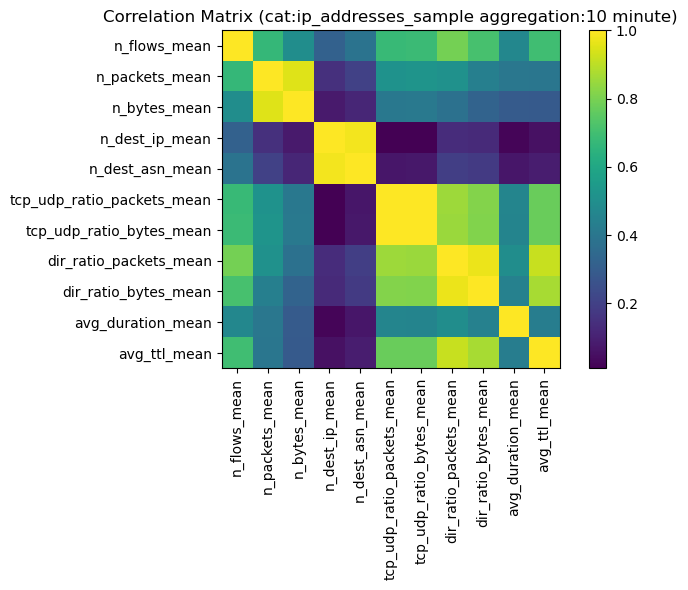

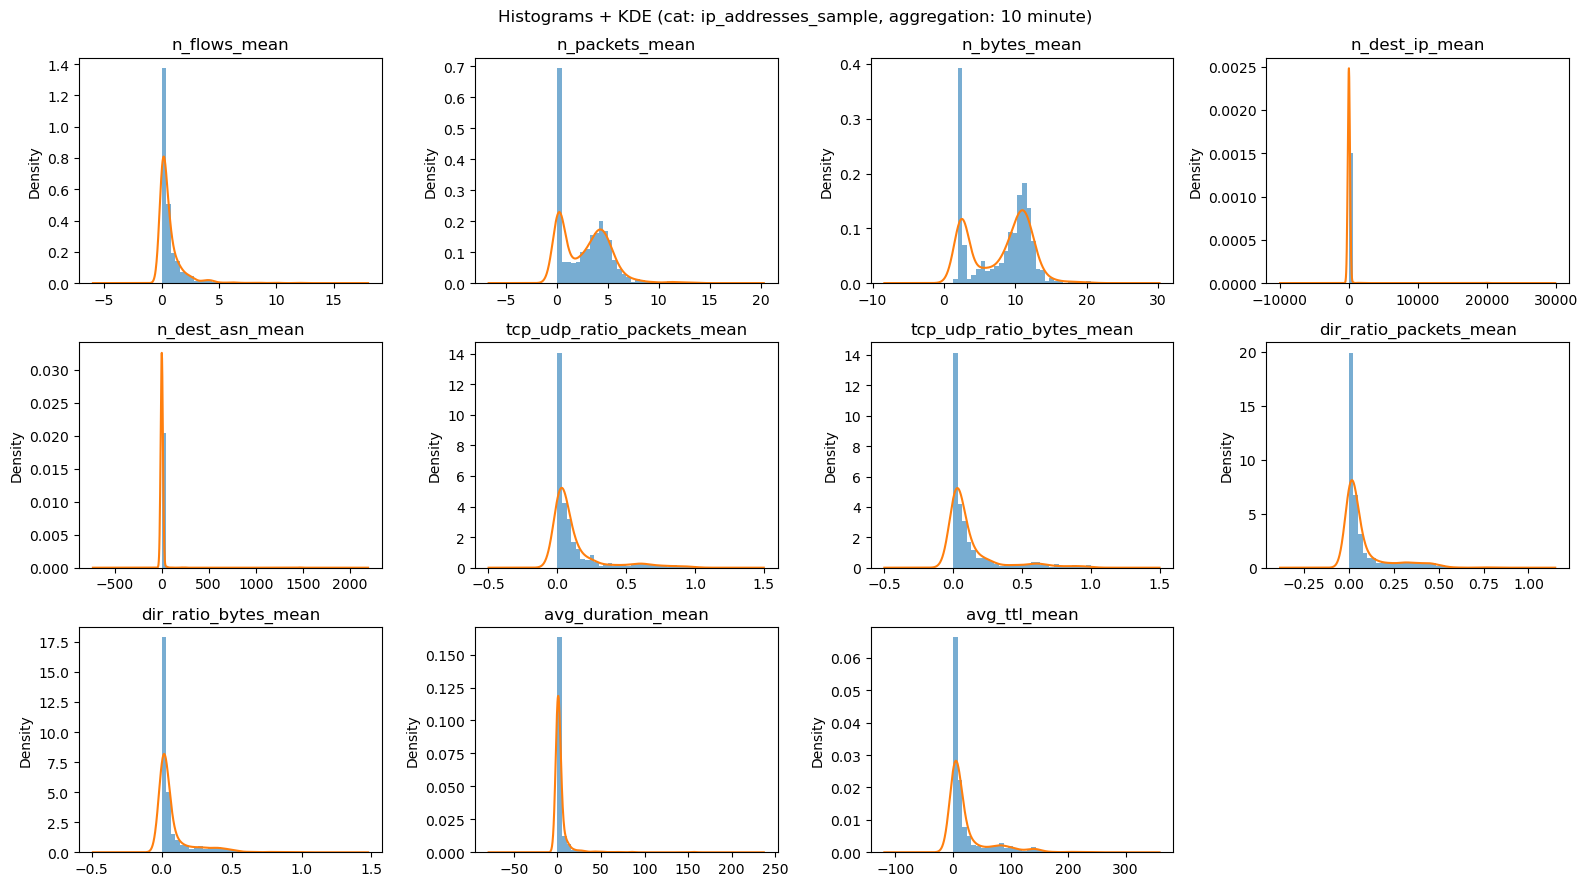


 Category:ip_addresses_sample at aggregation 1 hour


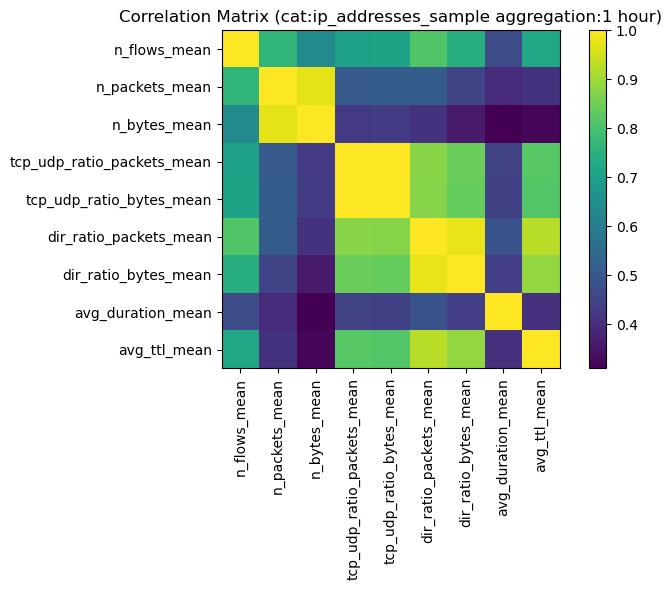

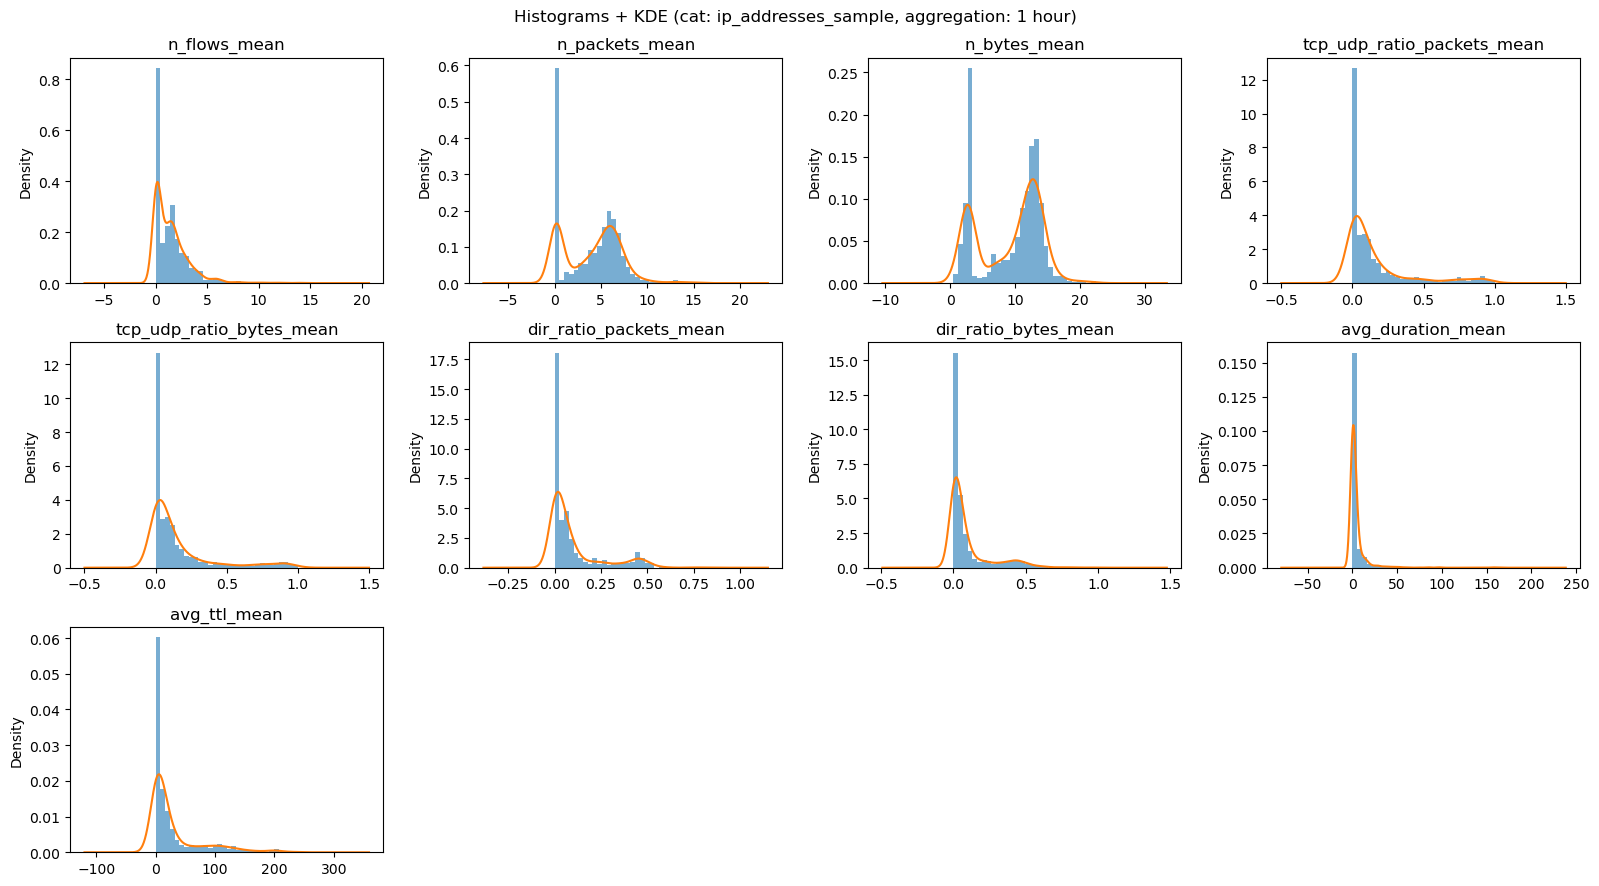


 Category:ip_addresses_sample at aggregation 1 day


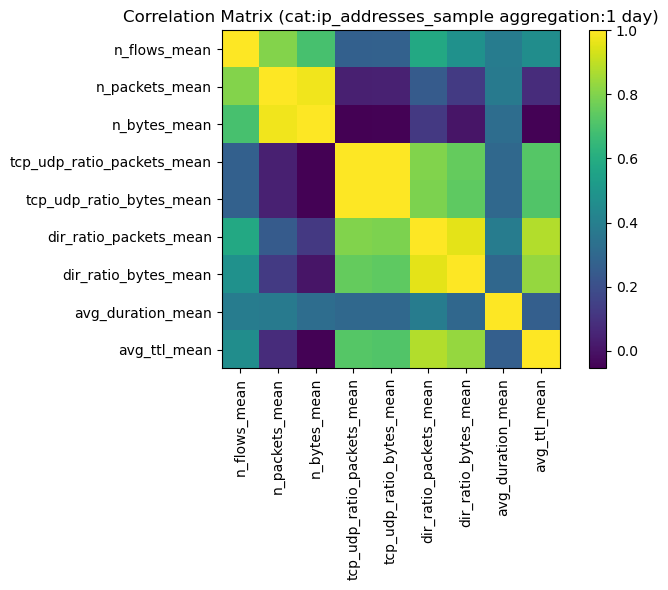

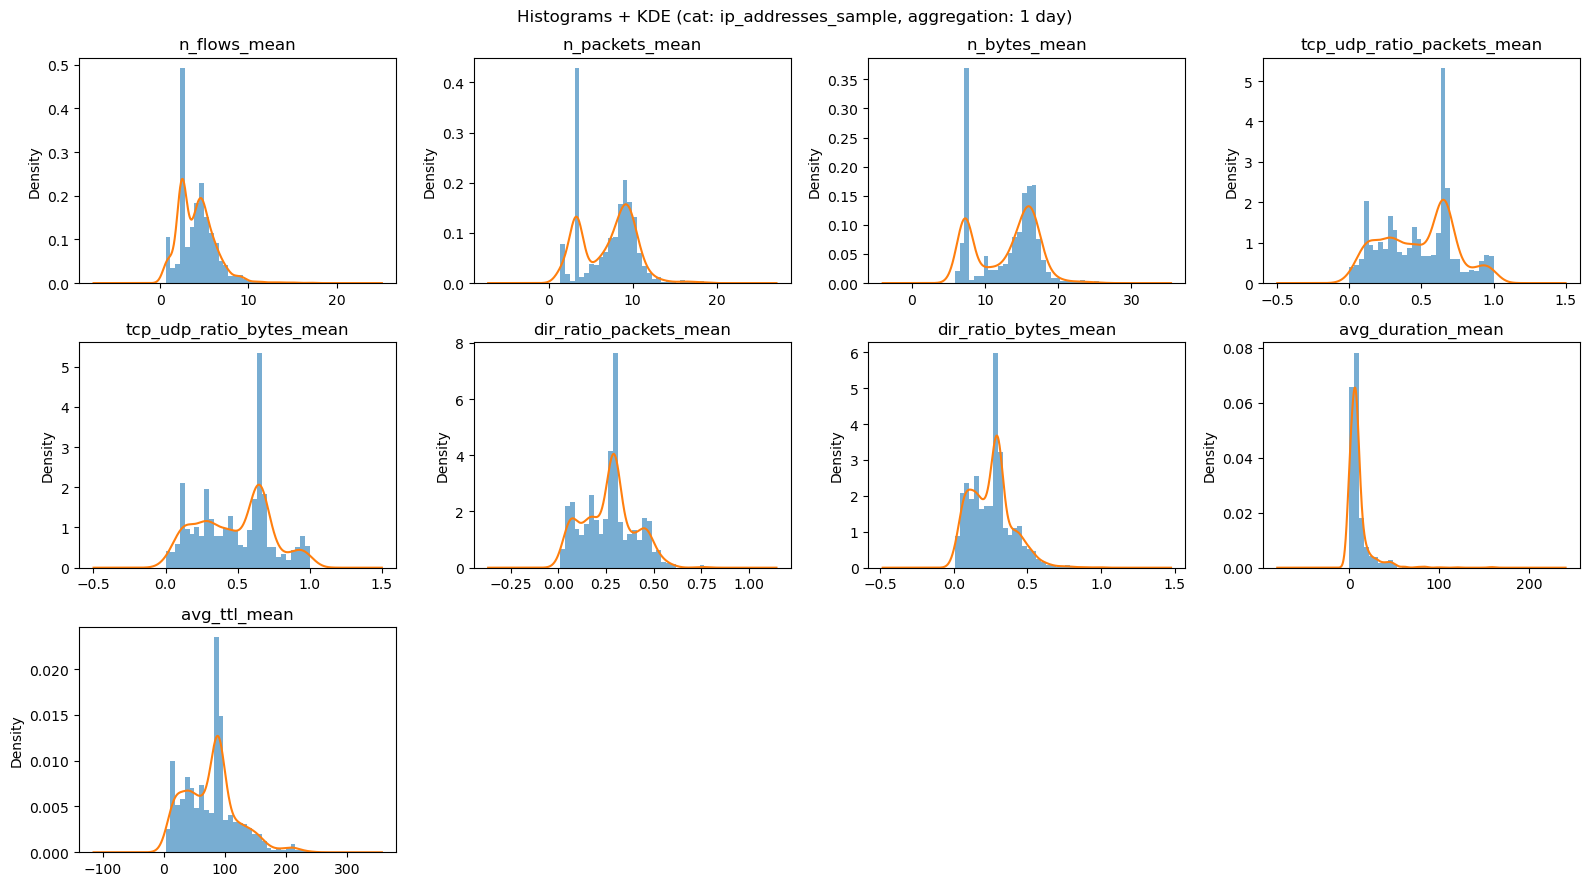


 Category:institutions at aggregation 10 minute


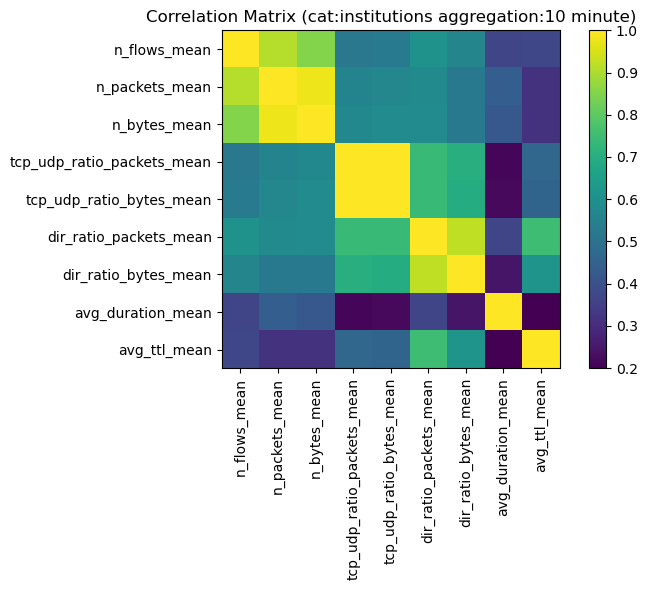

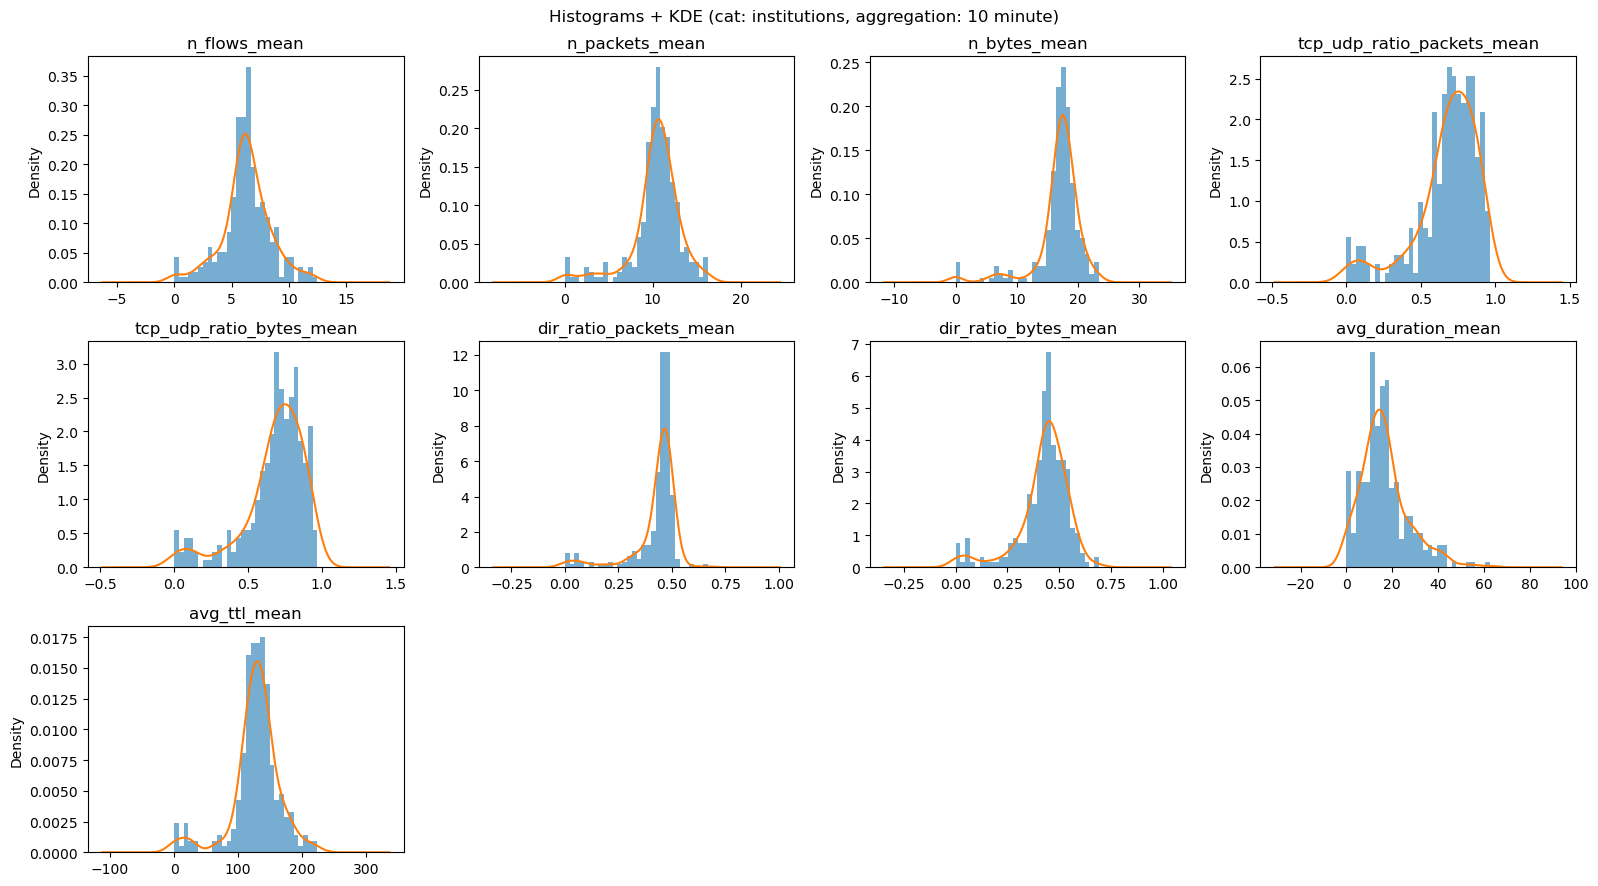


 Category:institutions at aggregation 1 hour


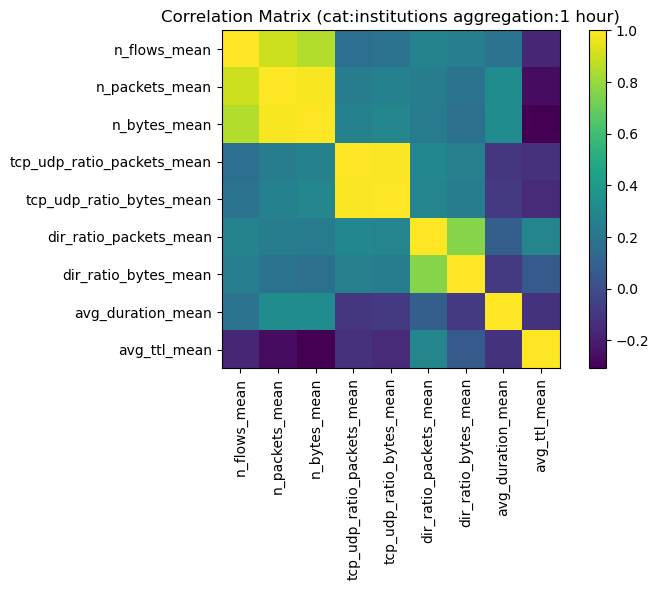

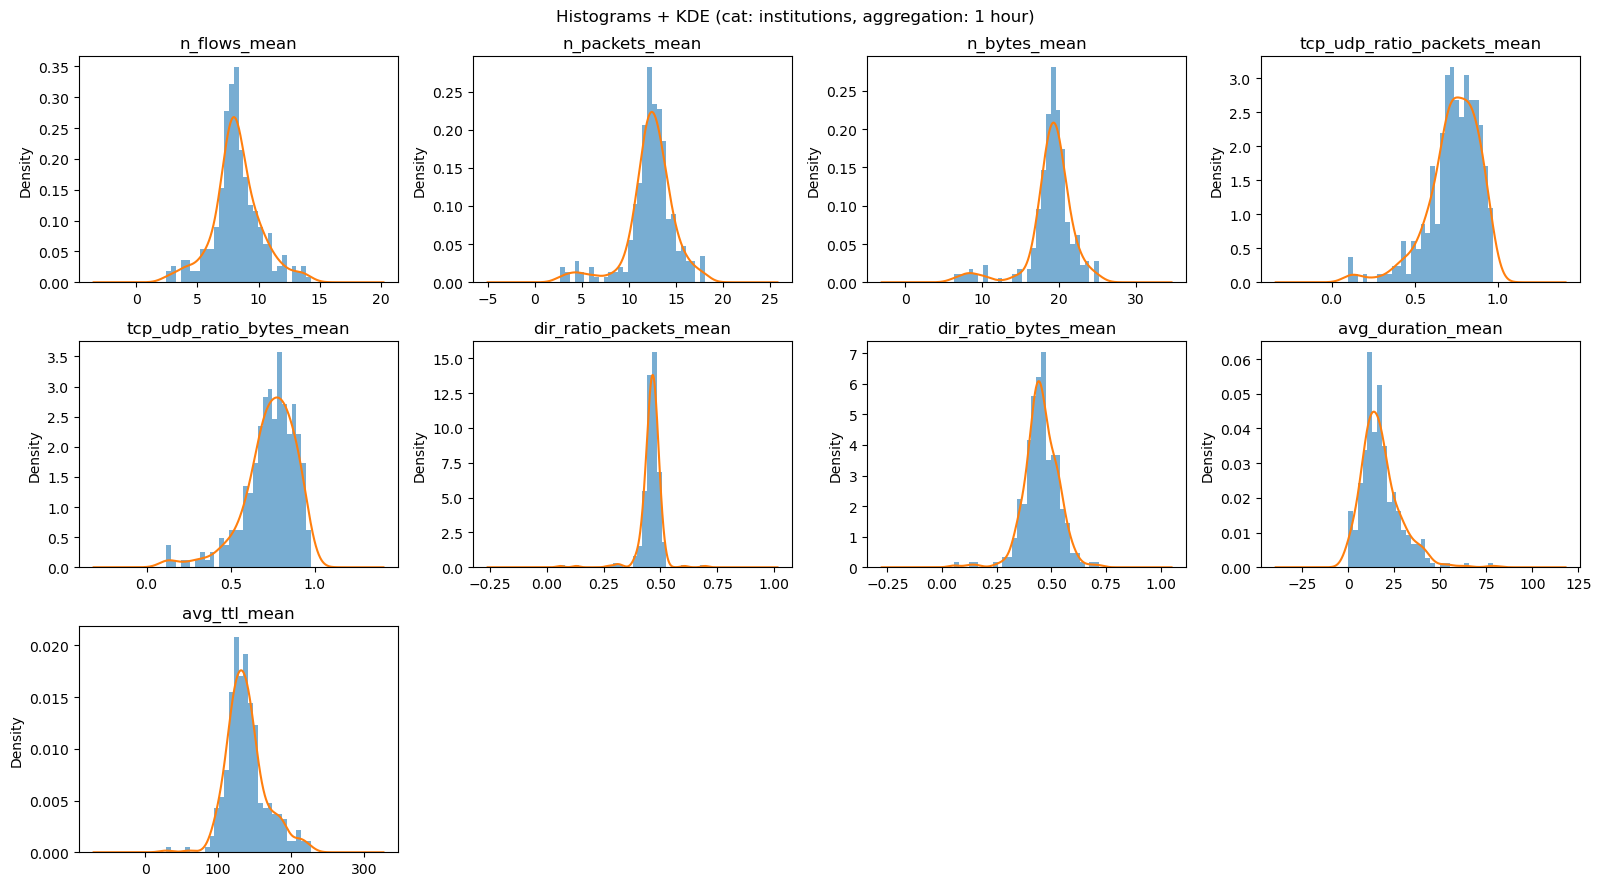


 Category:institutions at aggregation 1 day


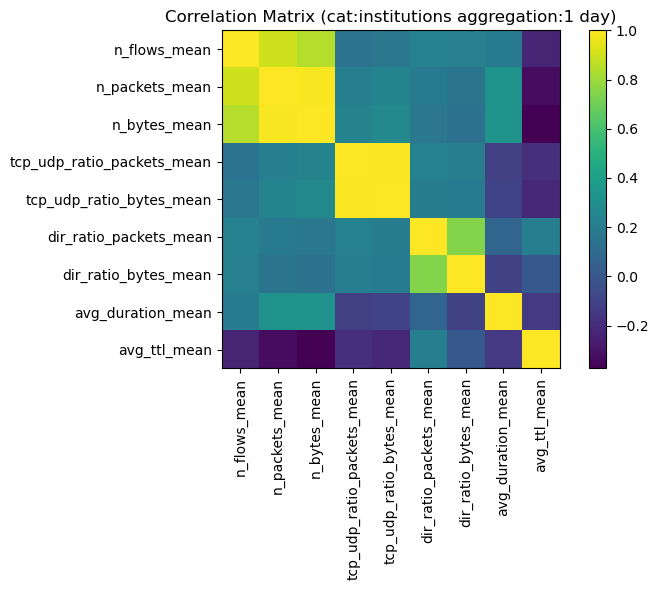

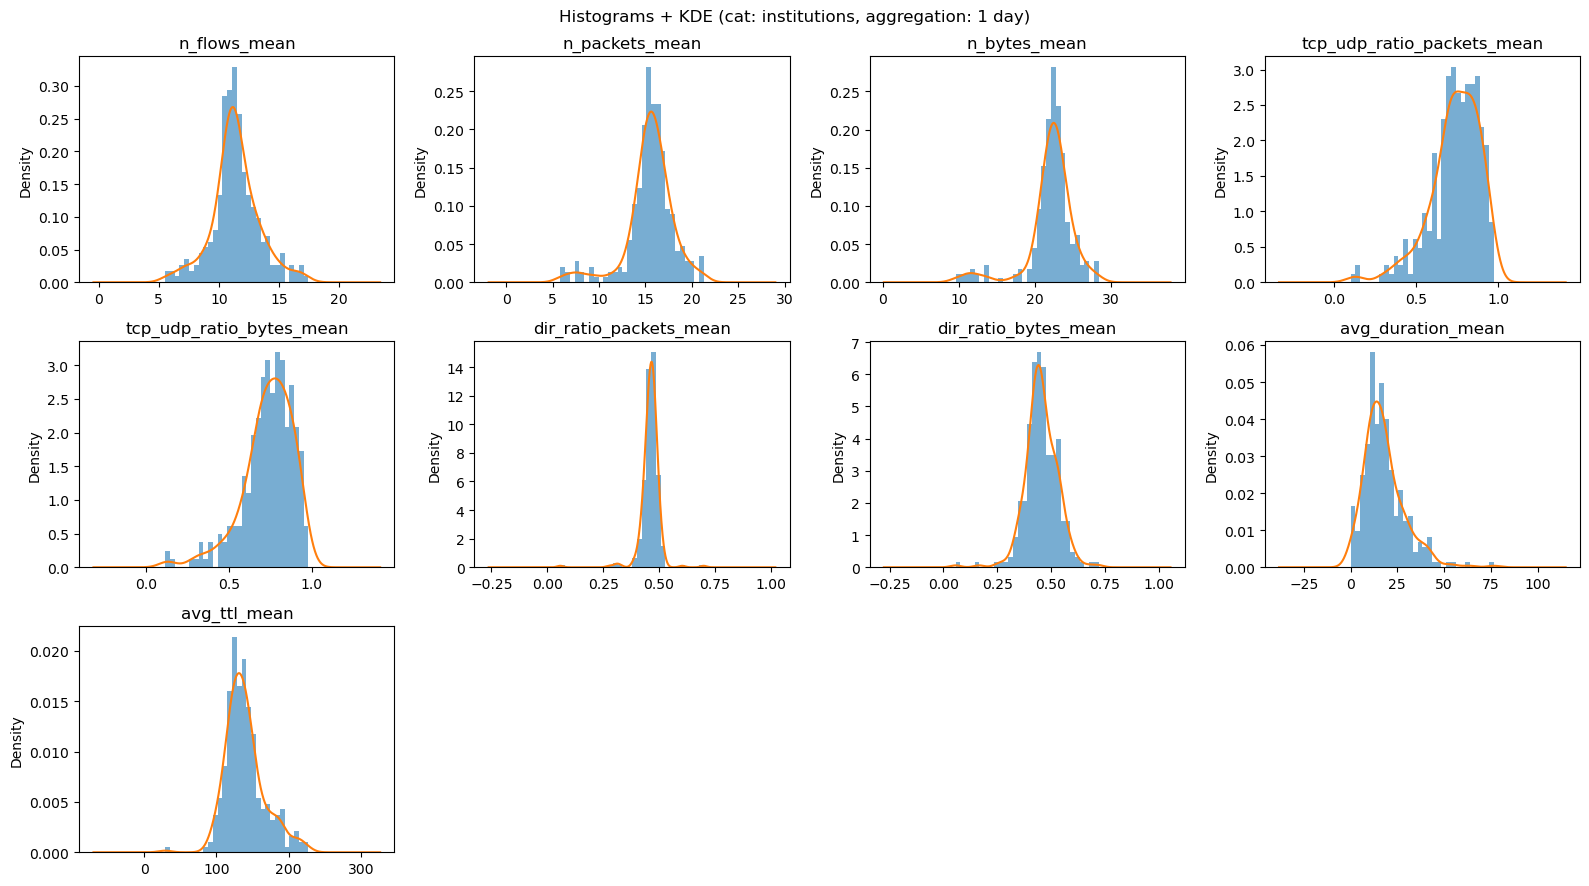


 Category:institution_subnets at aggregation 10 minute


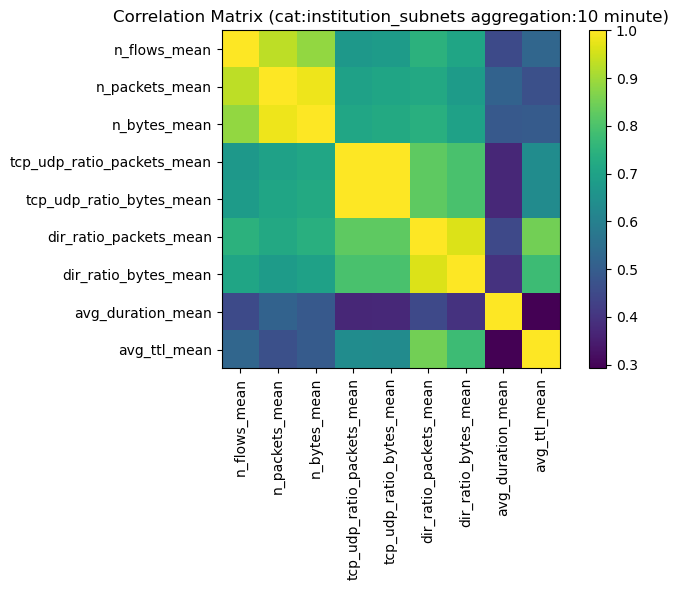

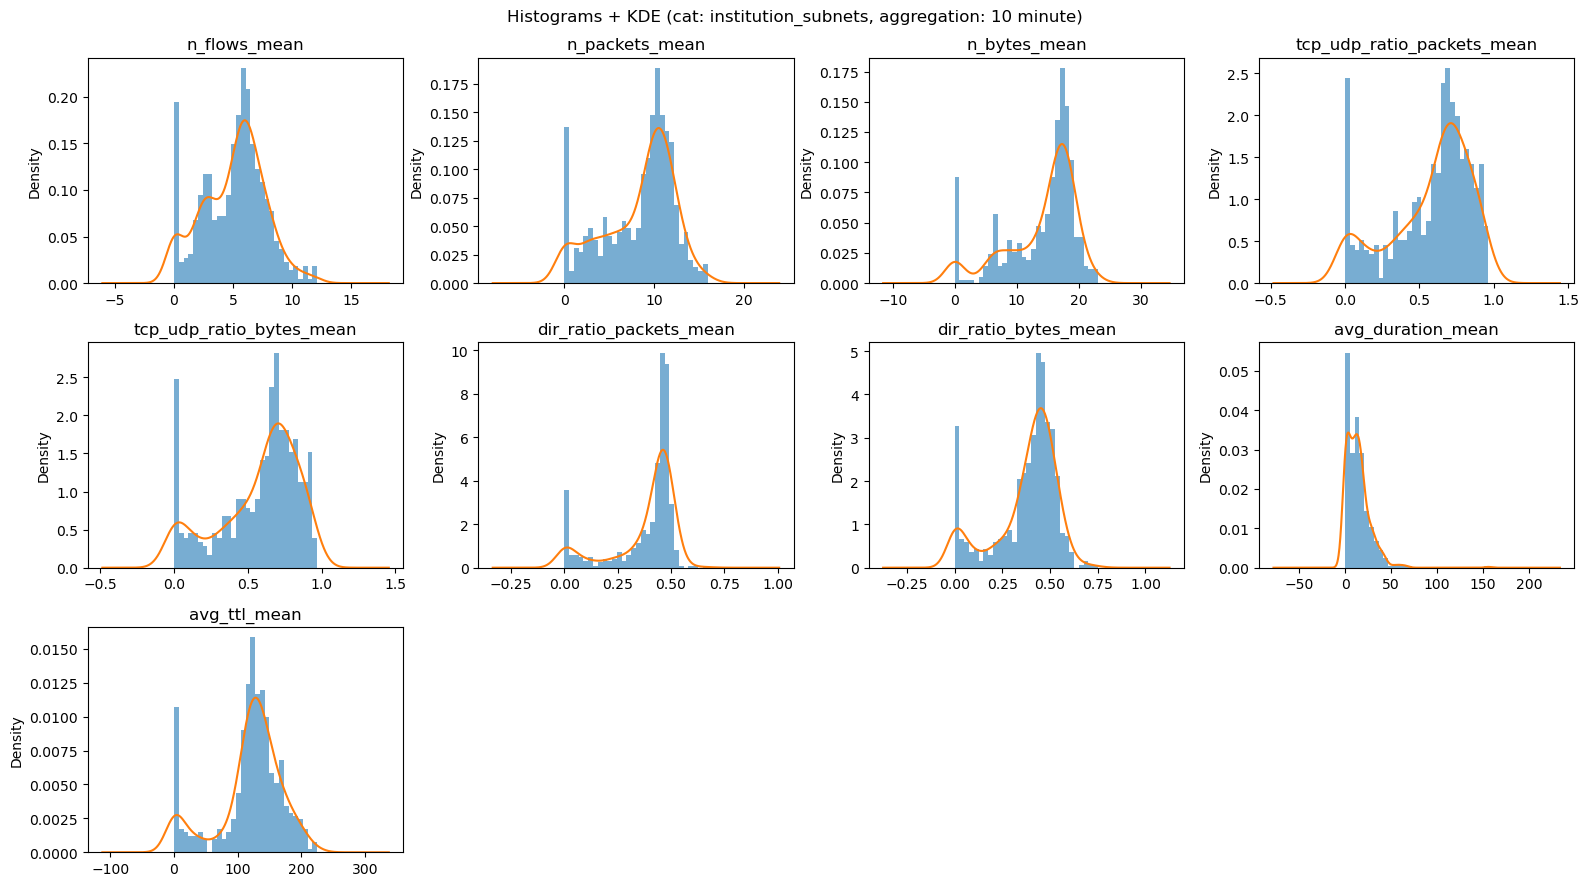


 Category:institution_subnets at aggregation 1 hour


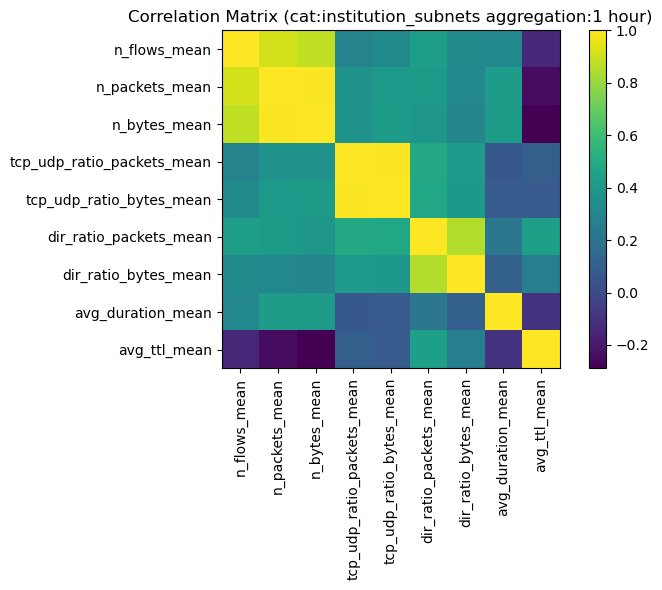

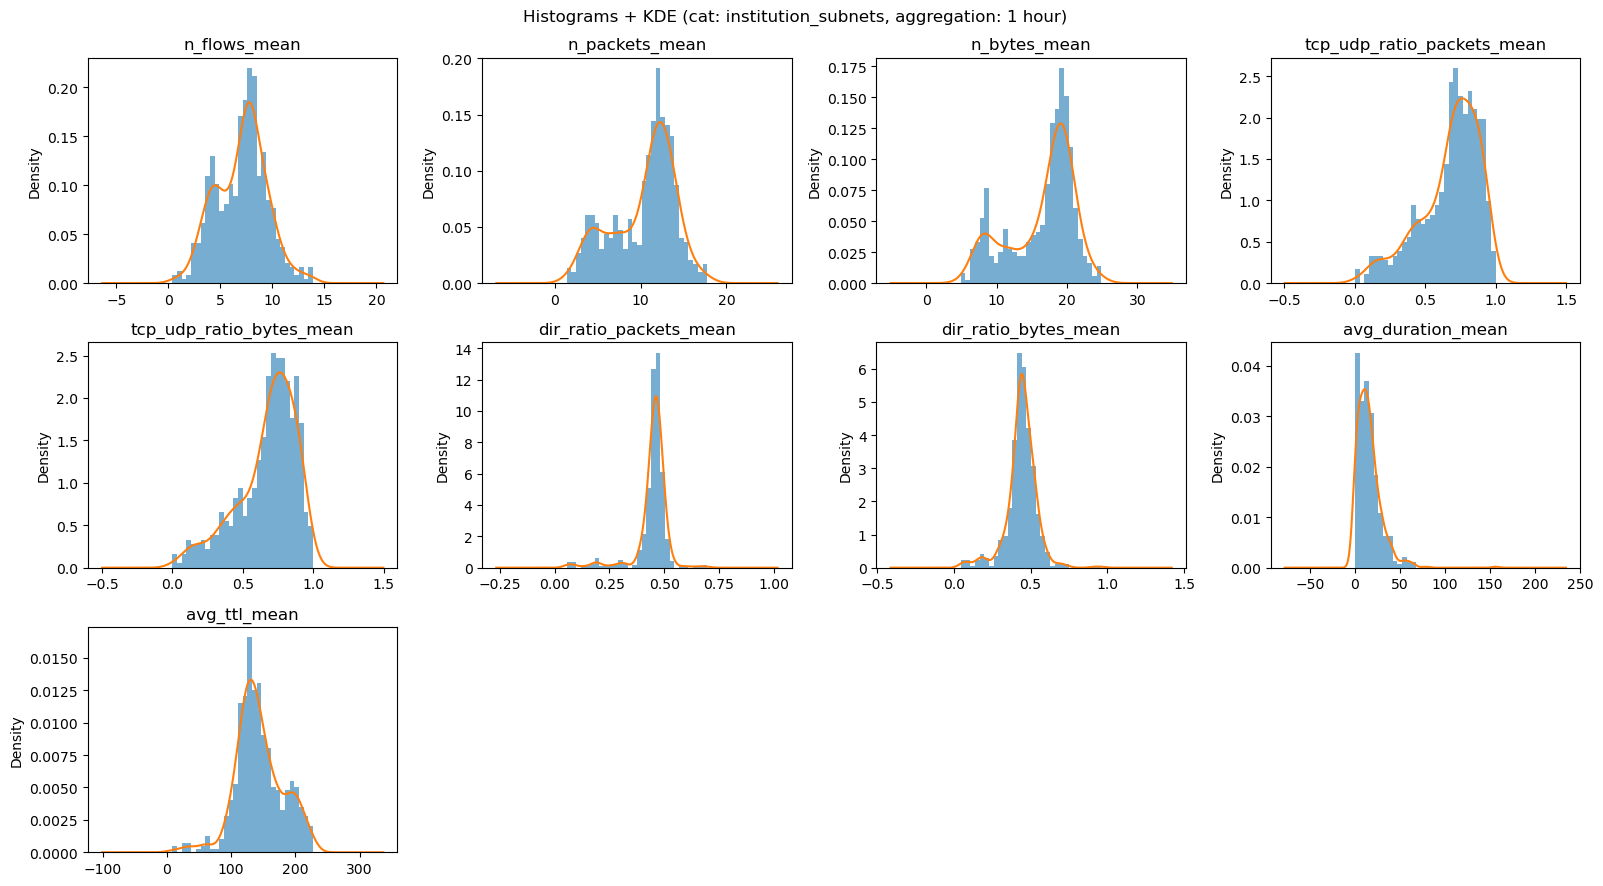


 Category:institution_subnets at aggregation 1 day


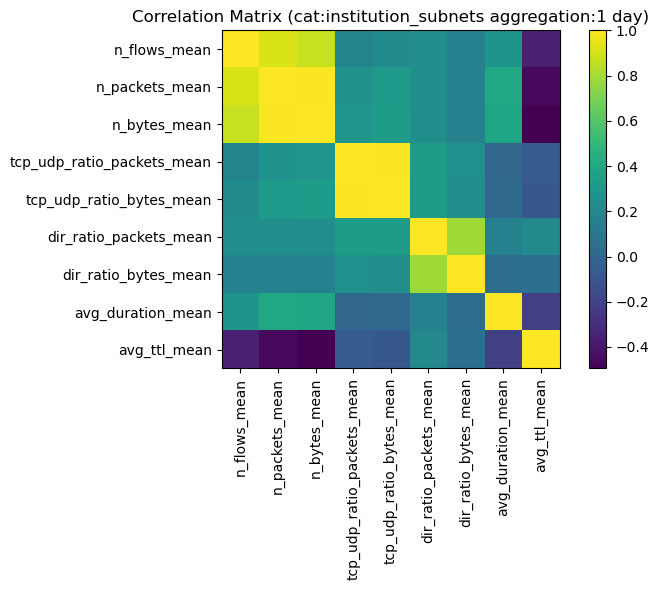

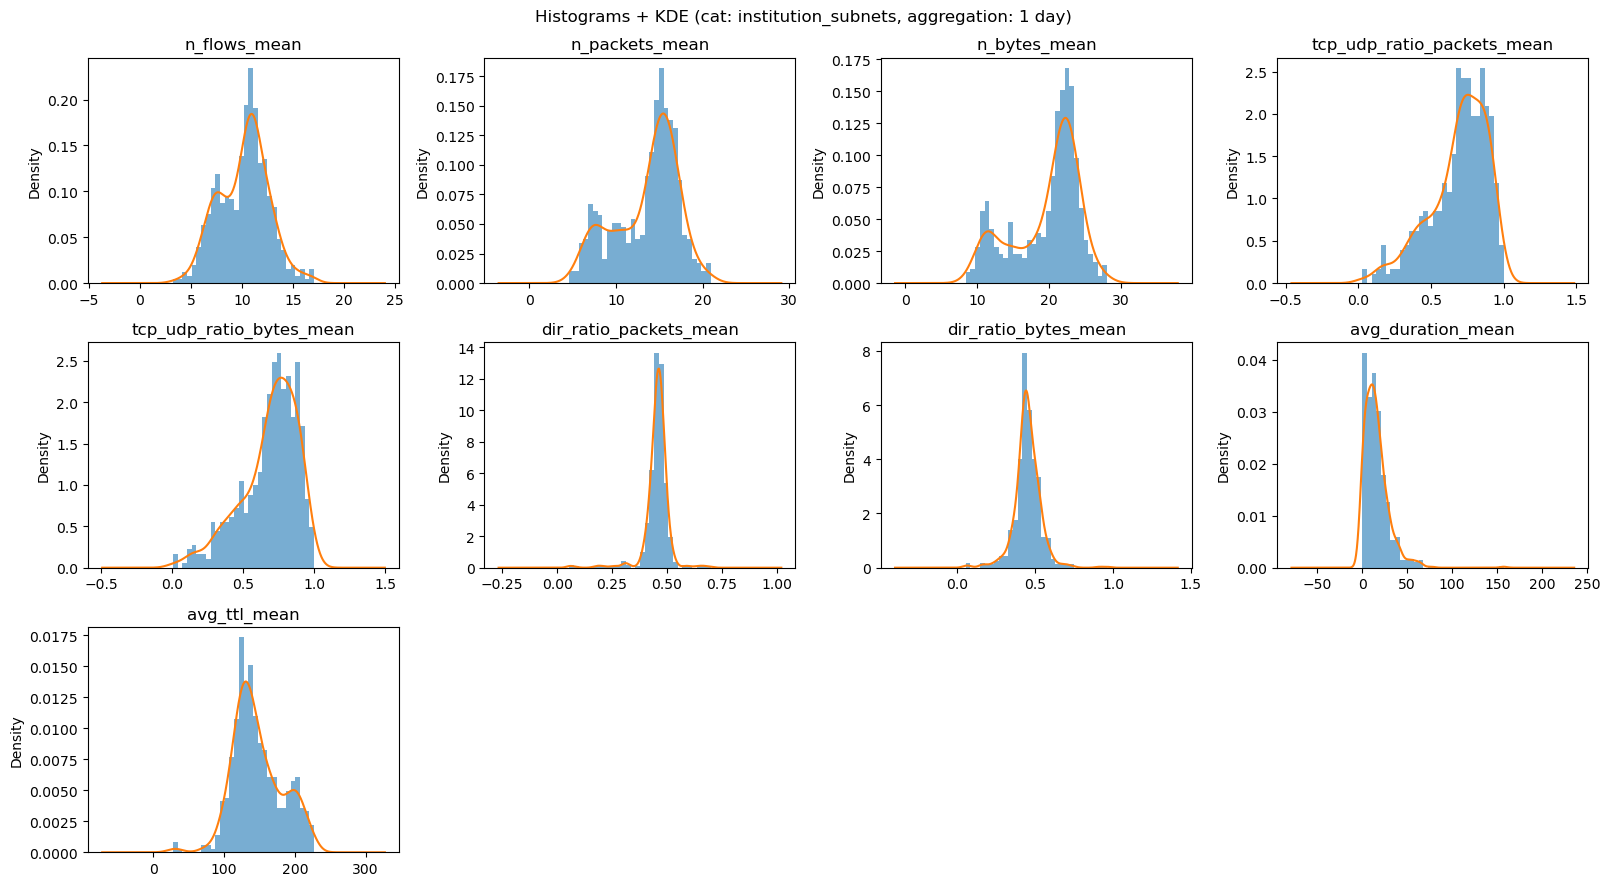

In [8]:
datasets = {
    'ip_addresses_sample': 'ip_addresses_sample',
    'institutions':   'institutions',
    'institution_subnets': 'institution_subnets'}
aggs = {
    '10 minute': {'agg': 'agg_10_minutes', 'time': 'times/times_10_minutes.csv'},
    '1 hour':    {'agg': 'agg_1_hour',     'time': 'times/times_1_hour.csv'},
    '1 day':    {'agg': 'agg_1_day',      'time': 'times/times_1_day.csv'},}
base_features = ['n_flows','n_packets','n_bytes','n_dest_ip','n_dest_asn','n_dest_port','tcp_udp_ratio_packets',
                 'tcp_udp_ratio_bytes','dir_ratio_packets','dir_ratio_bytes','avg_duration','avg_ttl']
# create histograms and correlation martix between each dir and aggregation
for cat, cat_dir in datasets.items():
    for agg_name, agg_dict in aggs.items():
        records = []
        print("\n Category:{} at aggregation {}".format(cat, agg_name))
        data_dir  = os.path.join(cat_dir, agg_dict['agg'])
        time_file = agg_dict['time']

        df_time = pd.read_csv(time_file)
        len_time = len(df_time)

        files = sorted(glob.glob(os.path.join(data_dir, '*.csv')))
        
        for fp in files:
            df = pd.read_csv(fp)
            t_col = 'id_time' if 'id_time' in df.columns else 'time' if 'time' in df.columns else df.columns[0]
            df = df.drop_duplicates(subset=t_col).set_index(t_col)
            df = df.reindex(pd.RangeIndex(len_time), fill_value=0)
            stats = {feat + '_mean': df[feat].mean() for feat in base_features if feat in df.columns}
            records.append(stats)

        df_stats = pd.DataFrame(records)
        cols = list(df_stats.columns)
        count_cols = [c for c in df_stats.columns if c in ['n_flows_mean', 'n_packets_mean', 'n_bytes_mean']]
        df_stats[count_cols] = np.log1p(df_stats[count_cols])

        # correlation matrix
        corr = df_stats.corr()
        plt.figure(figsize=(8, 6))
        plt.imshow(corr, aspect='equal')
        plt.colorbar()
        plt.xticks(range(len(corr)), corr.columns, rotation=90)
        plt.yticks(range(len(corr)), corr.index)
        plt.title("Correlation Matrix (cat:{} aggregation:{})".format(cat, agg_name))
        plt.tight_layout()
        plt.show()

        # histograms with KDE
        fig, axes = plt.subplots(3, 4, figsize=(16, 9))
        axes = axes.flatten()
        for i in range(len(cols)):
            ax = axes[i]
            series = df_stats[cols[i]]
            ax.hist(series, bins=30, density=True, alpha=0.6)
            series.plot.kde(ax=ax)
            ax.set_title(cols[i])
        for j in range(len(cols), len(axes)):
            fig.delaxes(axes[j])
        fig.suptitle("Histograms + KDE (cat: {}, aggregation: {})".format(cat, agg_name))
        fig.tight_layout()
        plt.show()


## Model
The model for this project consisted of PCA to reduce the features to the most representative and then fitting the data to a K-Means model. I chose K-Means because it seemed the most appropriate from the models we covered in class. I computed four statistics for each feature—mean, standard deviation, skewness, and kurtosis. Skewness and kurtosis were helpful in identifying long tails in the features, which could point to outliers. Next, I opted for the RobustScaler versus the StandardScaler because it handles skewed data and many outliers better. The StandardScaler’s sensitivity to outliers threw off the K-Means model. After scaling our data, we transformed it into an m-component space, choosing enough components to still explain 95% of the variance.

Selecting the number of clusters for K-Means was the hardest part of this notebook and led to many manual experiments. First, I plotted an elbow chart to narrow the choice, but I ultimately chose the k with the highest silhouette score. We then re-fit our final K-Means model on the PCA-reduced feature matrix. After converting the distances to each cluster’s center into z-scores, we calculated how many standard deviations away each IP address was. Finally, we flagged the IP addresses that were greater than 3σ away and labeled those as anomalies.



 Category:ip_addresses_sample at aggregation 10 minute
features:44 with PCA dimensions:1
K-Means K Value: 2


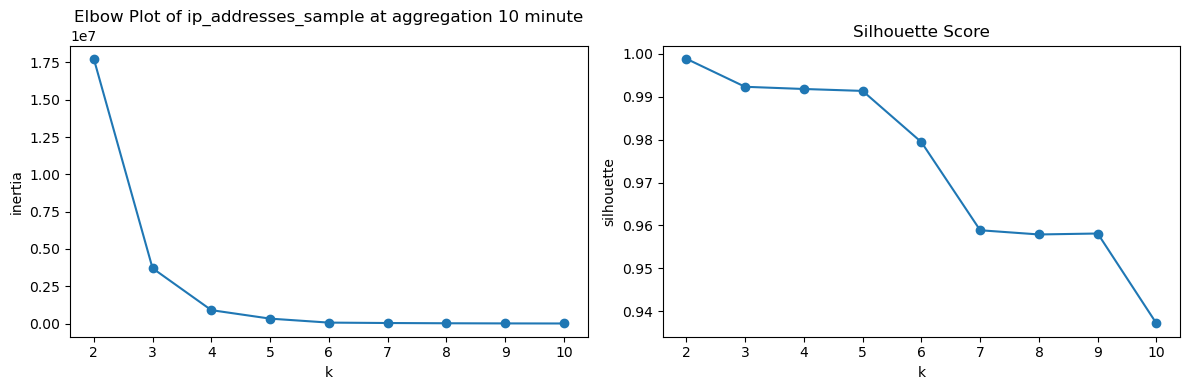

Anomlaies: 5/1000
Anomalous IP's: ['103', '11', '1368', '1656', '1852']

 Category:ip_addresses_sample at aggregation 1 hour
features:36 with PCA dimensions:1
K-Means K Value: 2


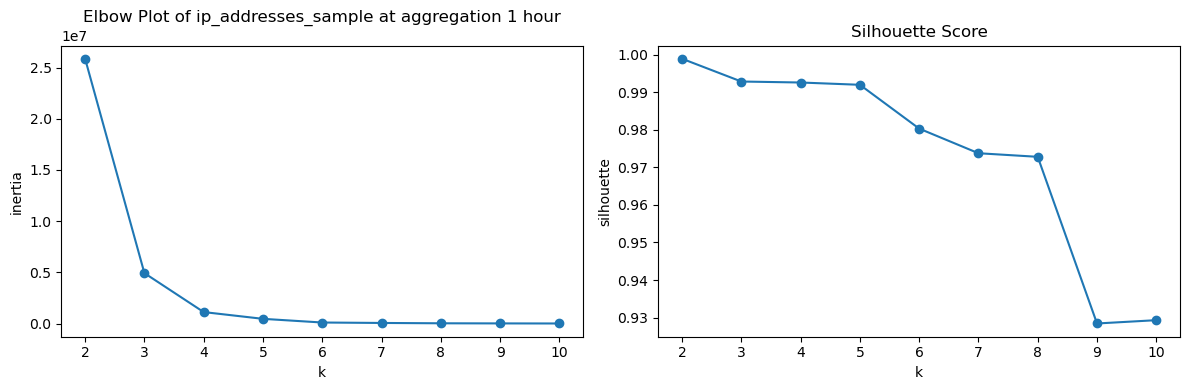

Anomlaies: 5/1000
Anomalous IP's: ['103', '11', '1368', '1656', '1852']

 Category:ip_addresses_sample at aggregation 1 day
features:36 with PCA dimensions:1
K-Means K Value: 2


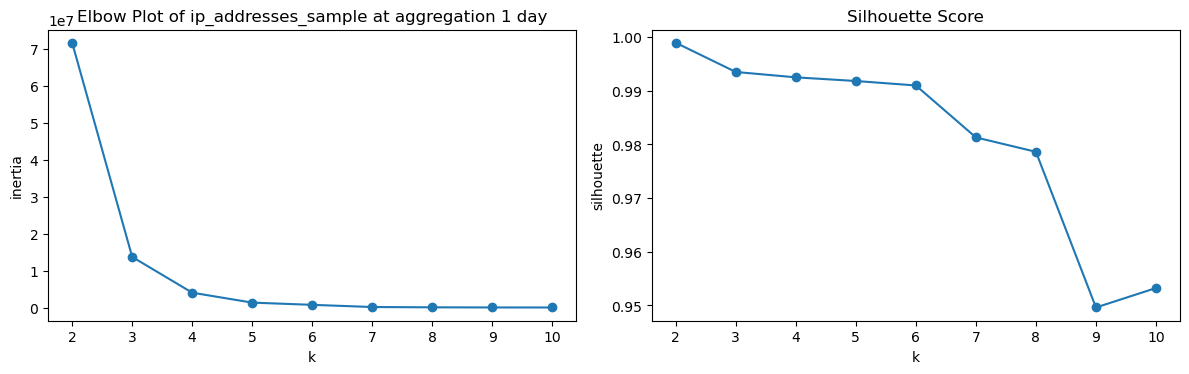

Anomlaies: 5/1000
Anomalous IP's: ['103', '11', '1368', '1656', '1852']

 Category:institutions at aggregation 10 minute
features:36 with PCA dimensions:4
K-Means K Value: 2


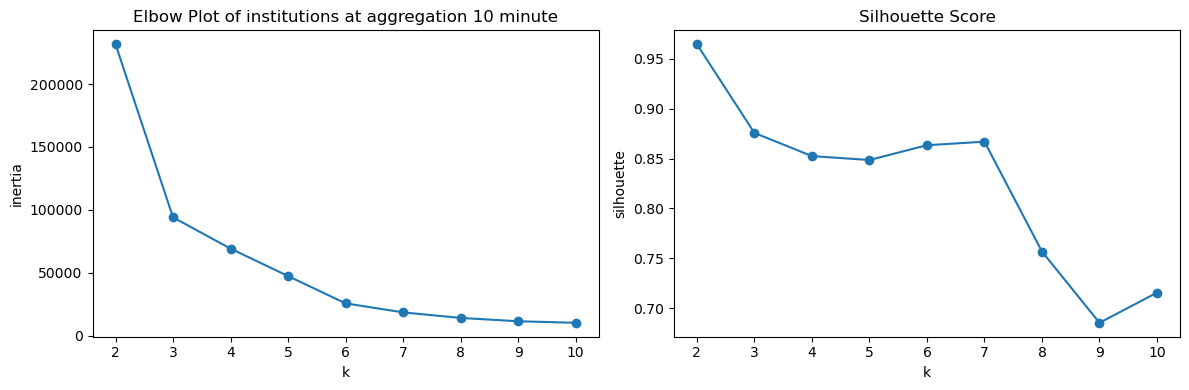

Anomlaies: 7/283
Anomalous IP's: ['150', '166', '266', '272', '275', '280', '282']


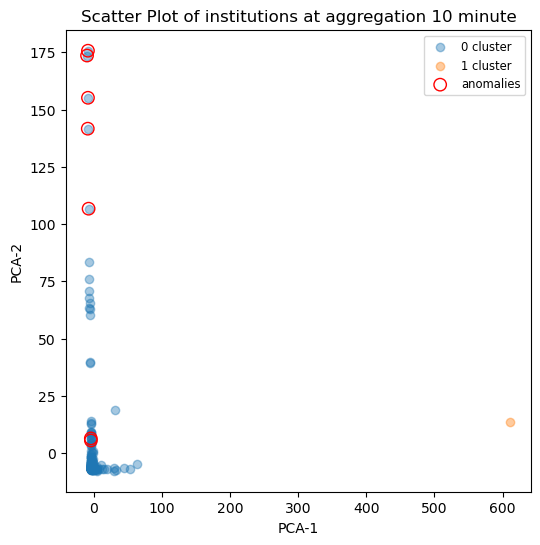


 Category:institutions at aggregation 1 hour
features:36 with PCA dimensions:5
K-Means K Value: 2


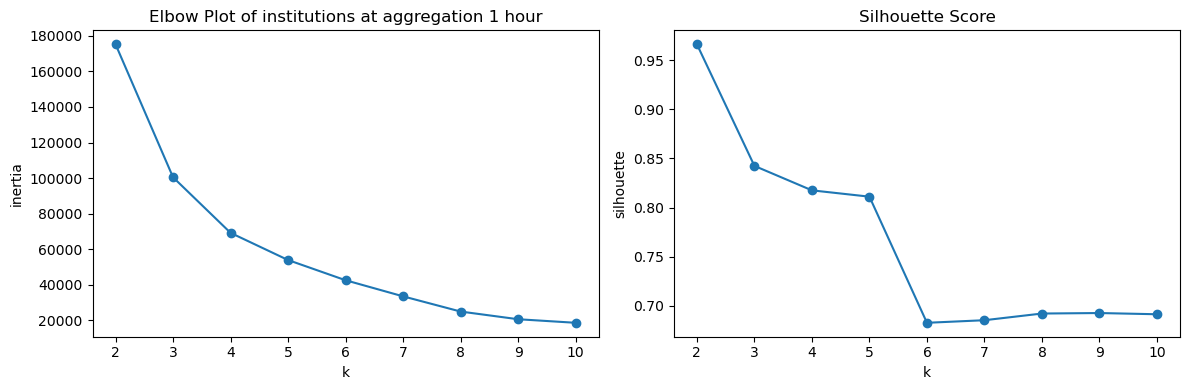

Anomlaies: 11/283
Anomalous IP's: ['0', '150', '175', '2', '267', '272', '275', '279', '47', '48', '49']


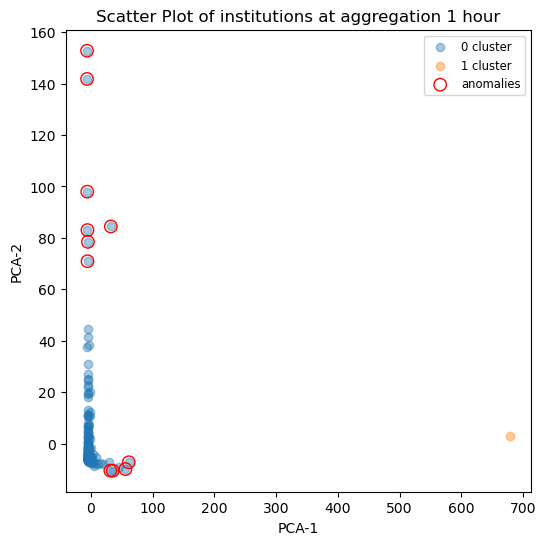


 Category:institutions at aggregation 1 day
features:36 with PCA dimensions:2
K-Means K Value: 2


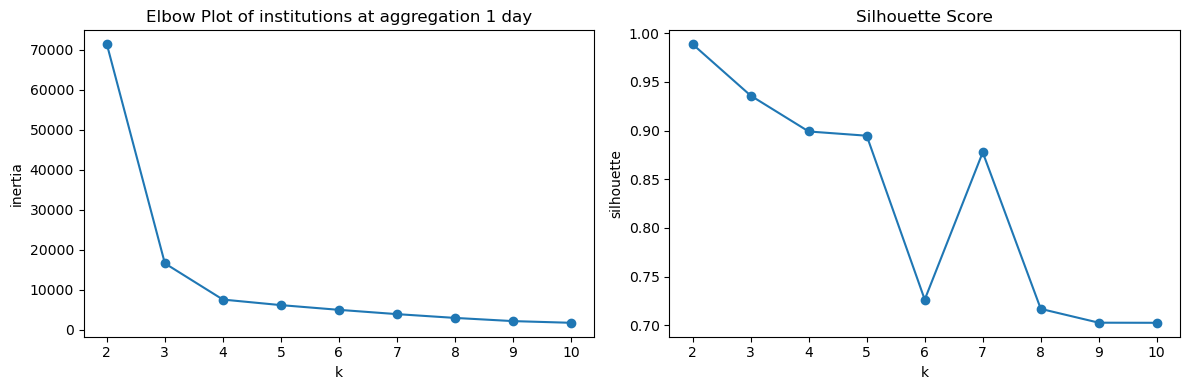

Anomlaies: 5/283
Anomalous IP's: ['0', '1', '2', '48', '49']


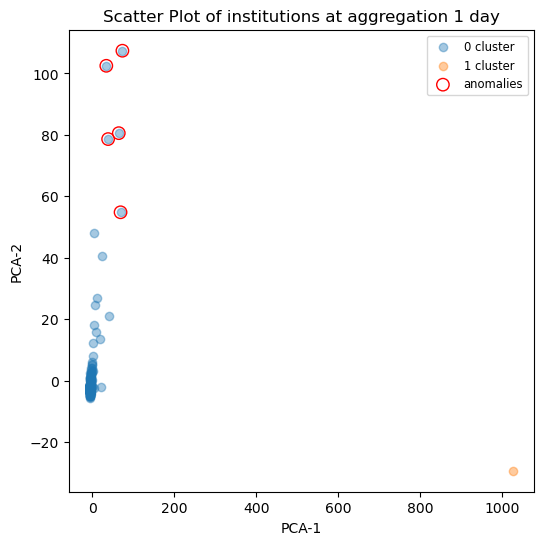


 Category:institution_subnets at aggregation 10 minute
features:36 with PCA dimensions:4
K-Means K Value: 2


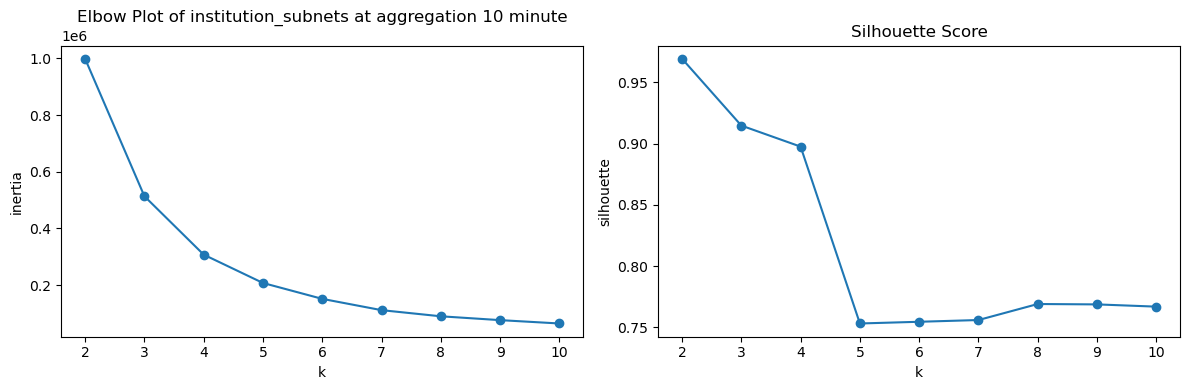

Anomlaies: 7/548
Anomalous IP's: ['140', '185', '215', '220', '351', '352', '513']


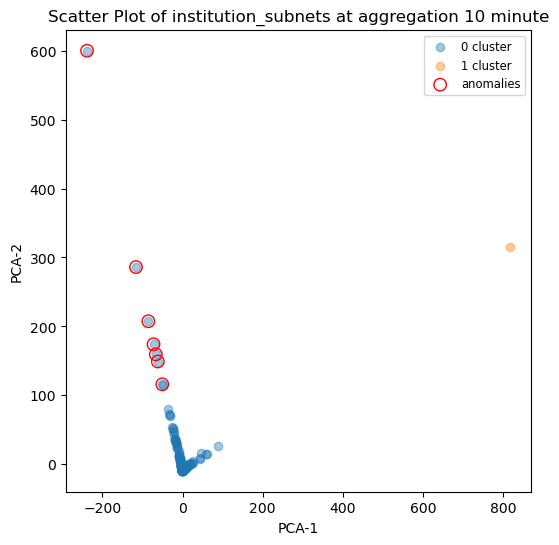


 Category:institution_subnets at aggregation 1 hour
features:36 with PCA dimensions:3
K-Means K Value: 2


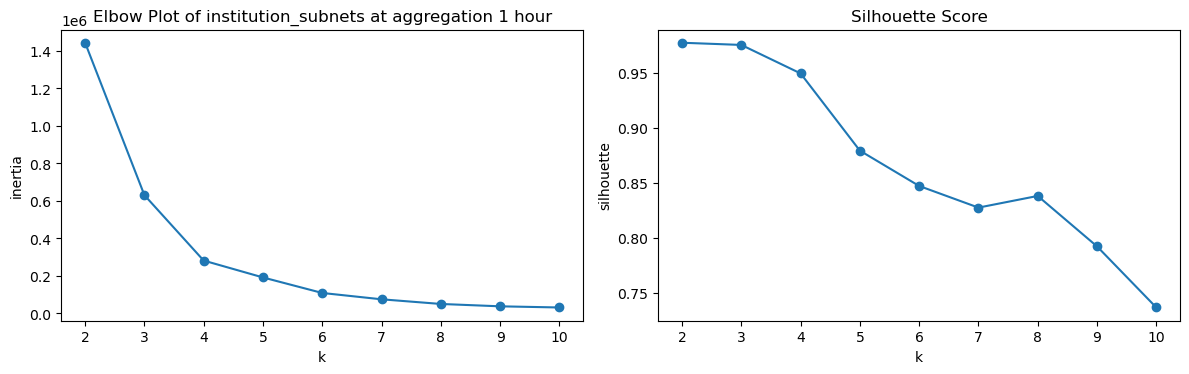

Anomlaies: 6/546
Anomalous IP's: ['139', '22', '352', '42', '472', '492']


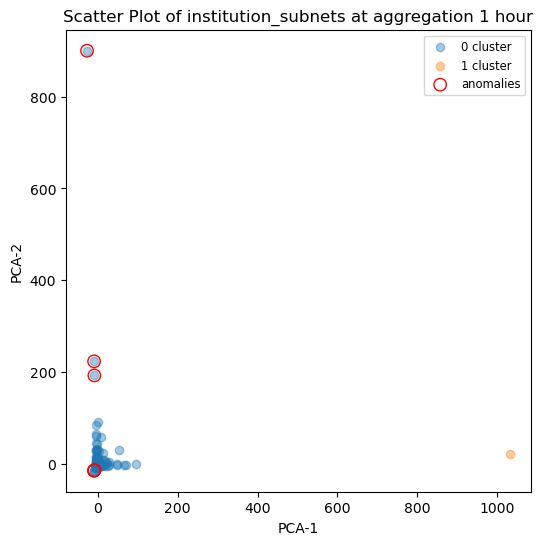


 Category:institution_subnets at aggregation 1 day
features:36 with PCA dimensions:2
K-Means K Value: 2


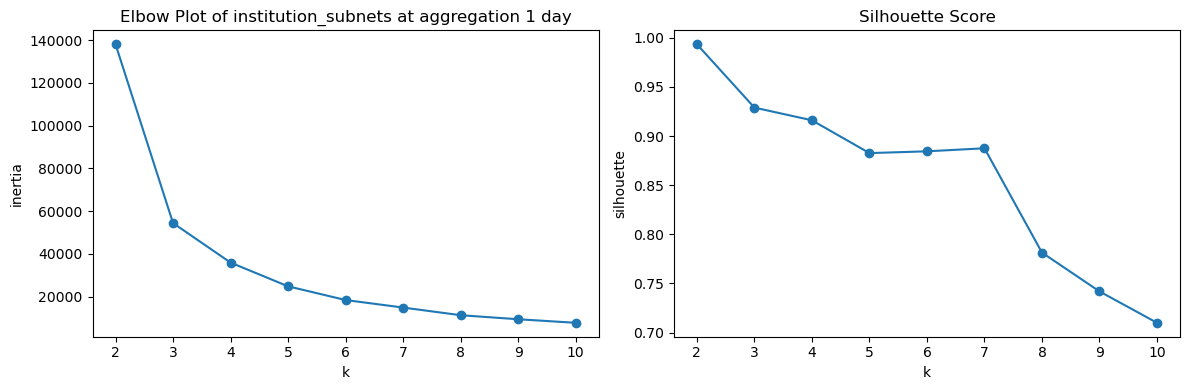

Anomlaies: 10/546
Anomalous IP's: ['0', '106', '126', '17', '200', '202', '242', '249', '29', '38']


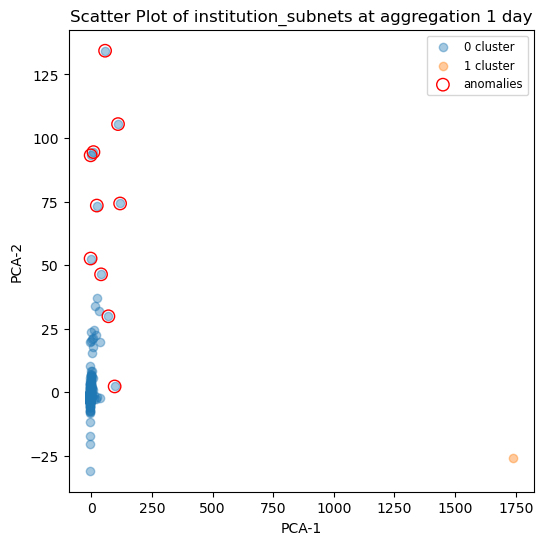

In [9]:
for cat, cat_dir in datasets.items():
    for agg_name, agg_dict in aggs.items():
        print("\n Category:{} at aggregation {}".format(cat, agg_name))
        data_dir  = os.path.join(cat_dir, agg_dict['agg'])
        time_file = agg_dict['time']
        df_time = pd.read_csv(time_file)
        len_time = len(df_time)
        files = sorted(glob.glob(os.path.join(data_dir, '*.csv')))
        records = []
        
        for fp in files:
            sid = os.path.splitext(os.path.basename(fp))[0]
            df  = pd.read_csv(fp)
            t_col = 'id_time' if 'id_time' in df.columns else 'time' if 'time' in df.columns else df.columns[0]
            # if 'id_time' in df.columns:   t_col = 'id_time'
            # elif 'time' in df.columns:    t_col = 'time'
            # else:                         t_col = df.columns[0]
            df = df.drop_duplicates(subset=t_col).set_index(t_col)
            df = df.reindex(pd.RangeIndex(len_time), fill_value=0)

            stats = {'series_id': sid}
            for feat in base_features:
                if feat in df.columns: 
                    arr = df[feat].values
                    stats['{}_mean'.format(feat)] = arr.mean()
                    stats['{}_std'.format(feat)]  = arr.std(ddof=0)
                    stats['{}_skew'.format(feat)] = pd.Series(arr).skew()
                    stats['{}_kurt'.format(feat)] = pd.Series(arr).kurtosis()
            records.append(stats)

        df_stats = pd.DataFrame(records).set_index('series_id')
        df_stats.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_stats.dropna(axis=1, how='all', inplace=True)
        df_stats.fillna(0, inplace=True) # for PCA, I got an error that there were nan values

        # log1p on known skewed features from kdes histograms above 
        for col in df_stats.columns:
            if col.endswith('_mean') and any(col.startswith(x) for x in
               ['n_flows','n_packets','n_bytes','n_dest']):
                df_stats[col] = np.log1p(df_stats[col])

        X = RobustScaler().fit_transform(df_stats)
        pca = PCA().fit(X)
        cumvar = np.cumsum(pca.explained_variance_ratio_)
        m = np.searchsorted(cumvar, 0.95) + 1
        X_pca = pca.transform(X)[:, :m]
        print("features:{} with PCA dimensions:{}".format(df_stats.shape[1], m))

        # calculate sihouette and elbow  
        inerts, sils = [], []
        ks = list(range(2, min(10, X_pca.shape[0]-1)+1))
        for k in ks:
            km = KMeans(n_clusters=k, n_init=10, random_state=42)
            lbl = km.fit_predict(X_pca)
            inerts.append(km.inertia_) # elbow
            sils.append(silhouette_score(X_pca, lbl)) # sil

        best_k = ks[int(np.nanargmax(sils))] # take best k from sil
        print("K-Means K Value: {}".format(best_k))

        # plot sihouette and elbow  
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
        ax1.plot(ks, inerts, marker='o')
        ax1.set_title("Elbow Plot of {} at aggregation {}".format(cat, agg_name))
        ax1.set_xlabel("k"); ax1.set_ylabel("inertia")
        ax2.plot(ks, sils, marker='o')
        ax2.set_title("Silhouette Score")
        ax2.set_xlabel("k"); ax2.set_ylabel("silhouette")
        plt.tight_layout()
        plt.show()


        km = KMeans(n_clusters=best_k, n_init=10, random_state=42)
        labels = km.fit_predict(X_pca)
        centers = km.cluster_centers_
        dists   = np.linalg.norm(X_pca - centers[labels], axis=1)
        z_dists = zscore(dists)

        # print anomalous IPs
        df_stats['cluster']  = labels
        df_stats['dist']     = dists
        df_stats['z_dist']   = z_dists
        df_stats['anomaly']  = np.abs(z_dists) > 3 # anomaly or not (3 std)
        anomalous_ids = df_stats.index[df_stats['anomaly']].tolist()

        print("Anomlaies: {}/{}". format(df_stats['anomaly'].sum(), len(df_stats)))
        print("Anomalous IP's: {}".format(anomalous_ids))
        
        # visualize k-means plot
        if m >= 2:
            plt.figure(figsize=(6,6))
            for cl in np.unique(labels):
                idx = labels == cl
                plt.scatter(X_pca[idx,0], X_pca[idx,1],label="{} cluster".format(cl), alpha=0.4)
            ano_idx = df_stats['anomaly'].values
            plt.scatter(X_pca[ano_idx,0], X_pca[ano_idx,1],facecolors='none', edgecolors='r', s=80,label='anomalies')
            plt.title("Scatter Plot of {} at aggregation {}".format(cat, agg_name))
            plt.xlabel("PCA-1"); plt.ylabel("PCA-2")
            plt.legend(loc='best', fontsize='small')
            plt.show()

## Results
For all nine experiments, K-Means gave a cluster size of two. The IP-addresses subset collapsed to one principal component and marked five IPs as anomalous. Institutions needed 4, 5, or 2 PCs to detect up to 11 anomalies. And the institution subnets reduced to 4, 3, and 2 dimensions and found 7, 6, and 10 anomalies respectively. Our PCA + K-Means model highlighted the IP addresses that are suspicious.
| Category          | Aggregation | Features | PCA Dims | K-Means k | Anomalies (count/total) |
|-------------------|-------------|---------:|---------:|----------:|------------------------:|
| IP                | 10min       |       44 |        1 |         2 |               5 / 1000 |
| IP                | 1hr         |       36 |        1 |         2 |               5 / 1000 |
| IP                | 1day        |       36 |        1 |         2 |               5 / 1000 |
| instit            | 10min       |       36 |        4 |         2 |                 7 / 283 |
| instit            | 1hr         |       36 |        5 |         2 |                11 / 283 |
| instit            | 1day        |       36 |        2 |         2 |                 5 / 283 |
| instit_subnet     | 10min       |       36 |        4 |         2 |                 7 / 548 |
| instit_subnet     | 1hr         |       36 |        3 |         2 |                 6 / 546 |
| instit_subnet     | 1day        |       36 |        2 |         2 |                10 / 546 |


## Discussion and Conclusion
Since starting this project, I’ve gained a lot of insight into what you can extract from the K-Means algorithm and how unsupervised learning methods are truly the “cake” of machine learning (reference to class lecture). The unsupervised approach demands more dedication to understanding your data, as well as tuning and iterating through the entire notebook at each step. This small step in detecting malicious actors on the network could be valuable for pointing out a bulk of IP addresses, but I think to improve this model I would like to work with real network traffic in addition to the provided counts. Being able to see real traffic, I think I could start to classify anomalies as actual attacks rather than just detect suspicious behavior. I also think another improvement would be to have some labeled “attack” data to train our clustering algorithms for detection. 

## Refrences
1. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
2. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html
4. https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
5. https://www.geeksforgeeks.org/how-to-calculate-skewness-and-kurtosis-in-python/
6. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html
7. https://zenodo.org/records/13382427
8. https://www.nature.com/articles/s41597-025-04603-x 